# Pump It Up: Data Mining the Water Table

## Contexto y origen de los datos  

En las zonas rurales de Tanzania, **millones de personas dependen de bombas manuales para acceder a agua potable**. Diversos estudios estiman que **entre un 30 % y un 40 % de estos puntos de agua están fuera de servicio en un momento dado**, lo que obliga a recorrer distancias largas o recurrir a fuentes inseguras. Anticipar qué bombas fallarán permite programar el mantenimiento antes de que ocurra la avería, optimizando los recursos limitados de ONG y autoridades locales y **garantizando un suministro continuo y seguro**.

**Proyecto & Fuente**  
Los datos proceden del **Taarifa Waterpoints Dashboard**, una iniciativa *open-source* que recopila y publica información del **Ministerio de Agua de Tanzania**.  
Taarifa funciona como un “gestor de incidencias del mundo físico”: los ciudadanos notifican problemas en infraestructuras, y los responsables municipales los priorizan y resuelven.  
Este conjunto concreto de registros sirvió de base al reto “**Pump It Up – Data Mining the Water Table**” organizado por DrivenData.

**Objetivo analítico**  
Predecir en qué estado operativo se encuentra cada punto de agua para orientar las tareas de mantenimiento y asegurar el suministro de agua potable.  
La variable a estimar (`status_group`) presenta **tres clases**:  

| Clase | Descripción | Implicación operativa |
|-------|-------------|-----------------------|
| `functional` | Bomba funciona sin incidencias | Visita rutinaria |
| `functional needs repair` | Funciona pero requiere reparación | Programar mantenimiento |
| `non functional` | Fuera de servicio | Intervención prioritaria |

Una predicción fiable de fallos permite **optimizar recursos** (tiempo de los técnicos, recambios, presupuesto) y **minimizar tiempos de inactividad** que afectan a las comunidades.

**Variables disponibles (extracto)**  

| Dimensión | Variables destacadas |
|-----------|----------------------|
| **Ubicación y topografía** | `latitude`, `longitude`, `gps_height`, `basin`, `region`, `district_code`, `lga`, `ward`, `subvillage` |
| **Construcción y hardware** | `construction_year`, `extraction_type`, `extraction_type_group`, `extraction_type_class`, `waterpoint_type`, `waterpoint_type_group` |
| **Gestión y financiación** | `funder`, `installer`, `scheme_management`, `management`, `management_group`, `payment`, `payment_type`, `permit` |
| **Demanda y contexto social** | `population`, `public_meeting` |
| **Calidad y cantidad de agua** | `water_quality`, `quality_group`, `quantity`, `quantity_group`, `source`, `source_type`, `source_class` |
| **Meta-datos de registro** | `date_recorded`, `recorded_by`, `wpt_name`, `num_private`, `amount_tsh` |

En total, el dataset incluye **≈ 37 atributos explicativos** (categóricos y numéricos) que capturan la **ubicación**, el **diseño técnico**, el **modelo de gestión** y el **entorno socio-demográfico** de cada bomba.  
Este abanico de factores ofrece una base rica para **explorar correlaciones** y **construir modelos predictivos** que apoyen la toma de decisiones sobre mantenimiento preventivo.


In [1]:
## lo básico
import pandas as pd
import numpy as np

## visualización
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

## pre procesado
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

## modelado
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## métricas
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import classification_report

## mejora de modelos
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

## automatización
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import impute as skl_imp

import math
from collections import Counter
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from scipy import stats
import missingno as msno
import mlflow
import mlflow.sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import ConfusionMatrixDisplay



# Análisis Exploratorio

## Importado de los datos.

### Carga de datos y unión de datasets.

In [2]:
train = pd.read_csv('datos/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
test = pd.read_csv('datos/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')
labels = pd.read_csv('datos/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')

In [3]:
datasets = (train, test, labels)

In [4]:
for x in datasets:
    print(x.shape)

(59400, 40)
(14850, 40)
(59400, 2)


### Unión de datos

In [5]:
train['dataset'] = 'train'
test['dataset'] = 'test'
df_train = pd.merge(train, labels, on='id', how='inner')

In [6]:
df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,dataset,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,train,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,train,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,train,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train,functional


In [7]:
df_final = pd.concat([df_train, test], axis=0)

## Exploracion inicial de los datos

In [8]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74250 entries, 0 to 14849
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69743 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74248 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lga    

In [9]:
df_final.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [31]:
report = ProfileReport(df_final)
report.to_file('df_final.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|          | 0/42 [00:00<?, ?it/s]
%|▏         | 1/42 [00:03<01:57,  2.86s/it]
%|▍         | 2/42 [00:03<01:01,  1.53s/it]
%|▋         | 3/42 [00:03<00:38,  1.01it/s]
%|▉         | 4/42 [00:04<00:31,  1.22it/s]
%|█▏        | 5/42 [00:04<00:25,  1.45it/s]
%|█▍        | 6/42 [00:05<00:19,  1.89it/s]
%|█▋        | 7/42 [00:05<00:15,  2.29it/s]
%|█▉        | 8/42 [00:05<00:11,  2.92it/s]
%|██▏       | 9/42 [00:07<00:31,  1.06it/s]
%|██▍       | 10/42 [00:07<00:23,  1.36it/s]
100%|██████████| 42/42 [00:09<00:00,  4.32it/s]
C:\Users\migue\anaconda3\envs\ML2025\Lib\site-packages\ydata_profiling\model\correlations.py:87: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'cannot reindex on an

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Tipos de variable

La variable `date_recorded` contiene la fecha de registro de cada observación, pero actualmente está almacenada como texto (`object`).  
Para poder trabajar correctamente con esta variable en análisis posteriores, se convertirá a tipo `datetime` utilizando `pd.to_datetime()`.

In [11]:
df_final['date_recorded'] = pd.to_datetime(df_final['date_recorded'], errors='coerce')

### Detección de errores de codificación en variables de alta cardinalidad

Algunas variables del dataset presentan una alta cardinalidad, es decir, un número muy elevado de categorías distintas.  
Para identificar posibles errores de codificación (por ejemplo, diferencias por espacios, mayúsculas o errores ortográficos), se normalizarán los textos y se revisarán aquellas categorías que aparecen con muy baja frecuencia (menos de 5 veces).


In [27]:
# Hacemos una lista de las variables de alta cardinalidad. 
vars_high_cardinality = ['funder', 'installer', 'scheme_name', 'ward', 'lga']

# Para cada variable en la lista
for var in vars_high_cardinality:
    print(f'\nVariable: {var}')
        
    # Normalizamos texto: minúsculas, quitamos espacios
    temp_series = df_final[var].astype(str).str.lower().str.strip()
    
    # Vemos las categorías que aparecen menos de 5 veces
    rare_categories = temp_series.value_counts()[temp_series.value_counts() < 5]
    
    # Mostramos las rarezas
    print(f'Número de categorías raras (<5 apariciones): {len(rare_categories)}')
    print(rare_categories.head(10))  



Variable: funder
Número de categorías raras (<5 apariciones): 1511
funder
railway                          4
netherland                       4
saleh zaharani                   4
h/w                              4
schoo                            4
scott                            4
wvc                              4
colonial government              4
koica and tanzania government    4
simavi                           4
Name: count, dtype: int64

Variable: installer
Número de categorías raras (<5 apariciones): 1525
installer
lgcdg                        4
tanas                        4
marti                        4
cast                         4
kk                           4
gachuma ginery               4
geita goldmain               4
patuu                        4
ha                           4
nyakilangani construction    4
Name: count, dtype: int64

Variable: scheme_name
Número de categorías raras (<5 apariciones): 1239
scheme_name
kipara                               4
mahanj  

No se detectan errores de codificación evidentes.  
Las categorías poco frecuentes se tratarán posteriormente mediante agrupación o codificación específica antes del modelado.

## Inspección gráfica de variables

### Distribuciones y calidades de las variables  

Antes de construir el pipeline es clave **ver la forma y la calidad** de cada variable para:

1. Detectar **asimetrías extremas** y decidir transformaciones (log, binning).
2. Localizar **outliers reales** frente a errores de captura.
3. Identificar **categorías con muy poca frecuencia** que generen ruido al codificar.
4. Marcar **ausencias** que puedan ser informativas (p. ej. permisos desconocidos).

En los siguientes gráficos se muestran:
- **Boxplots** para variables numéricas  
- **Histogramas** para categóricas de baja cardinalidad (< 20 niveles)  

Al final de la sección resumimos los hallazgos y cómo se plasman en el preprocesado.



In [31]:
num_vars = df_final.select_dtypes(include='number').columns.tolist()
low_cardinality_vars = []
for var in df_final.select_dtypes(include='object').columns:
    if df_final[var].nunique() < 20:
        low_cardinality_vars.append(var)

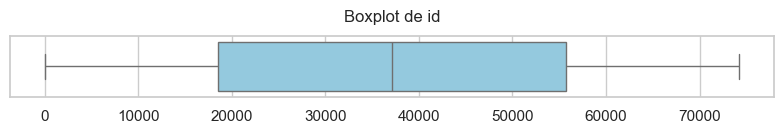

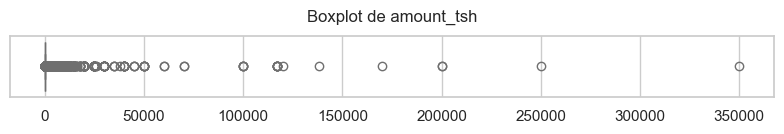

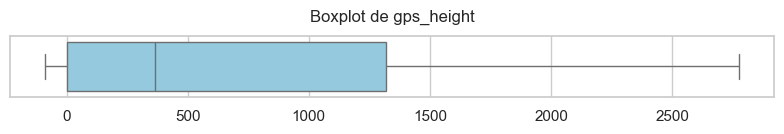

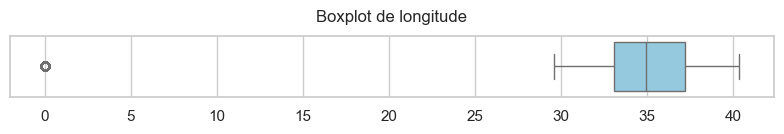

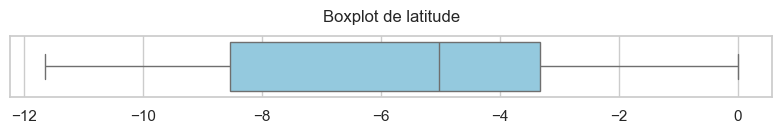

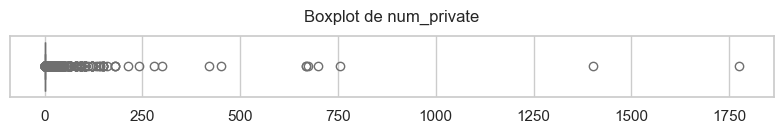

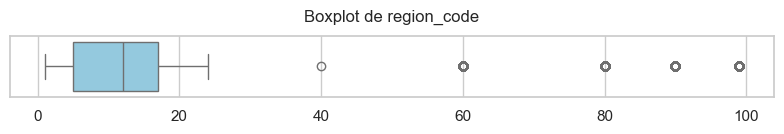

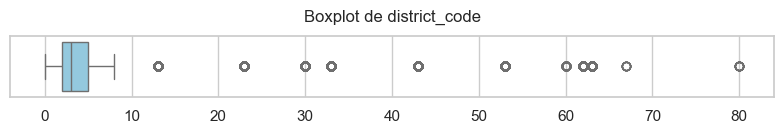

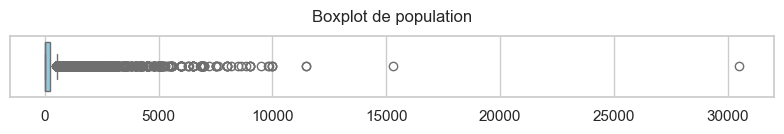

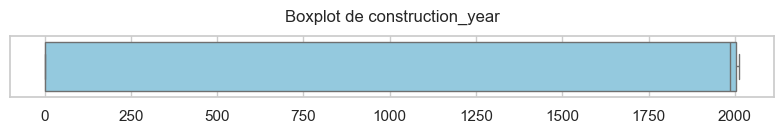

In [37]:
sns.set(style="whitegrid")

for var in num_vars:
    plt.figure(figsize=(8, 1.5))  
    sns.boxplot(x=df_final[var], color="skyblue", linewidth=1)
    plt.title(f'Boxplot de {var}', fontsize=12, pad=10)
    plt.xlabel('')
    plt.yticks([])
    plt.tight_layout()
    plt.show()

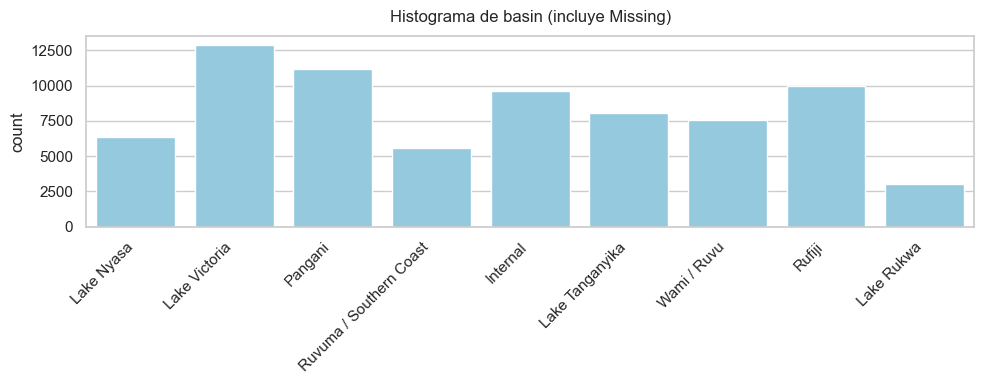

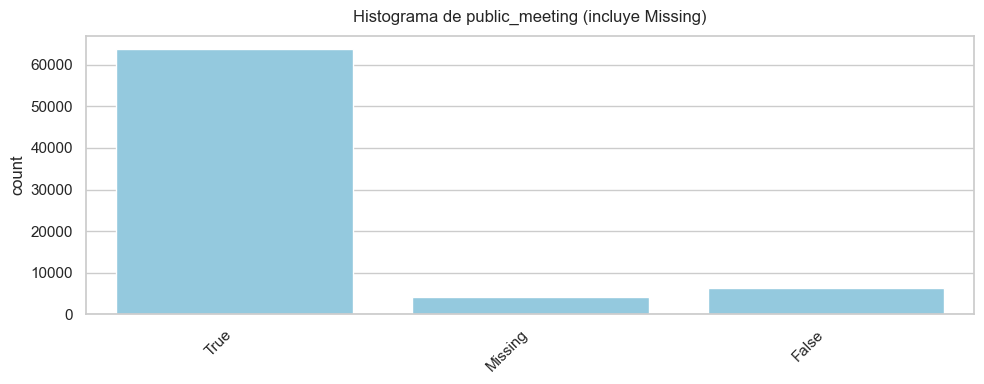

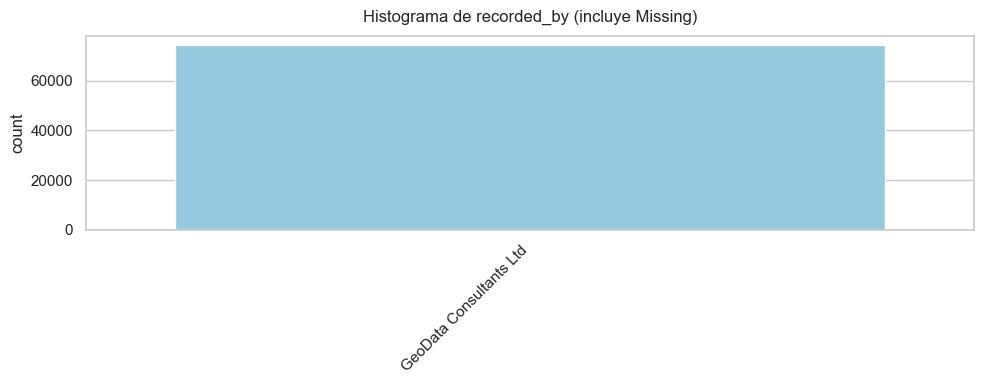

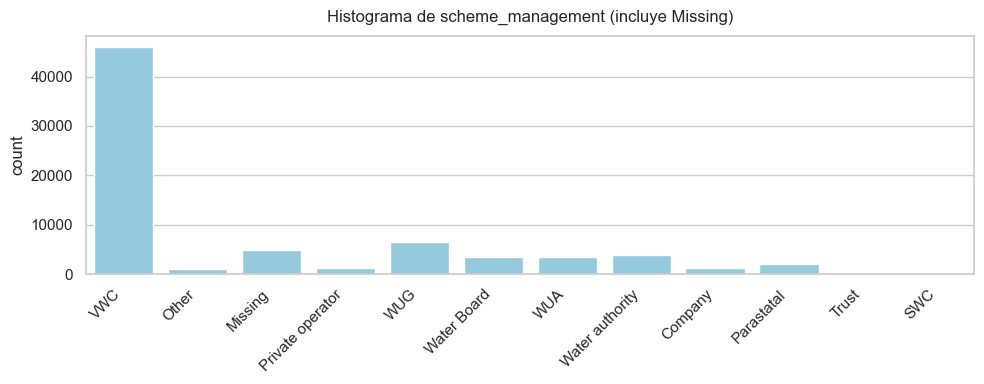

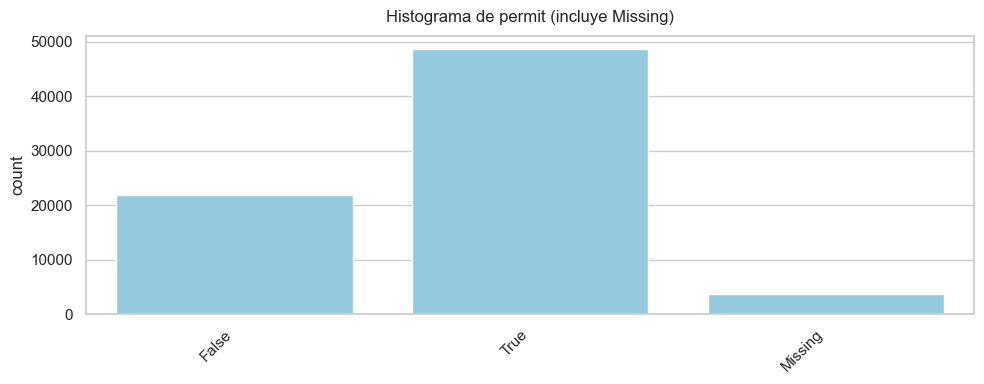

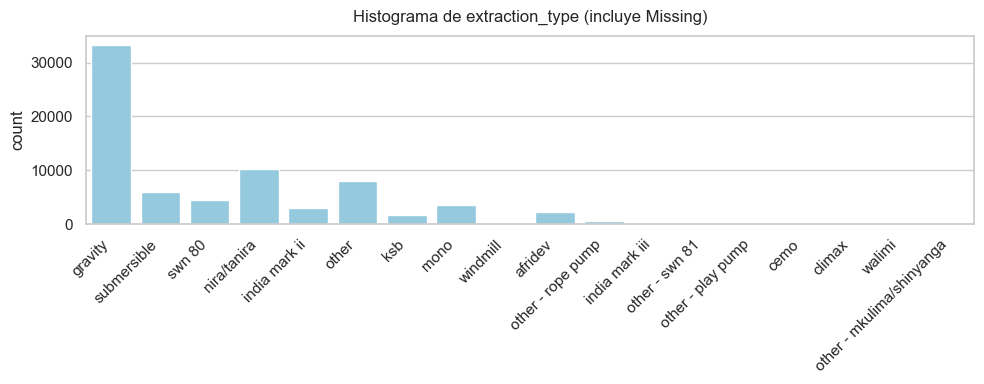

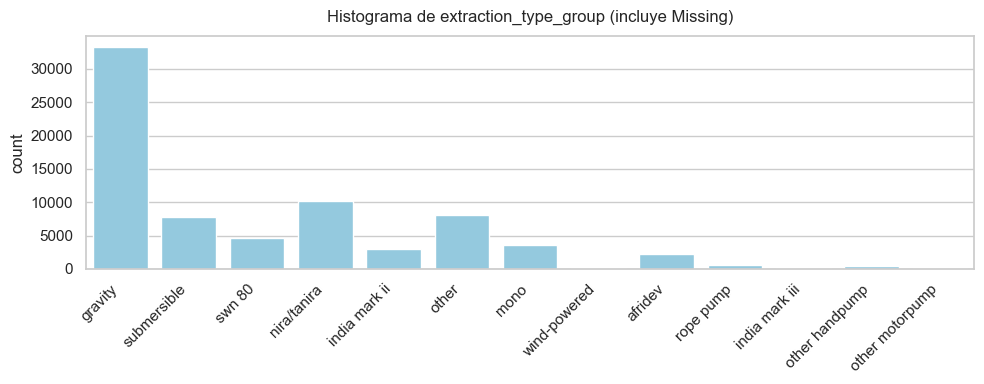

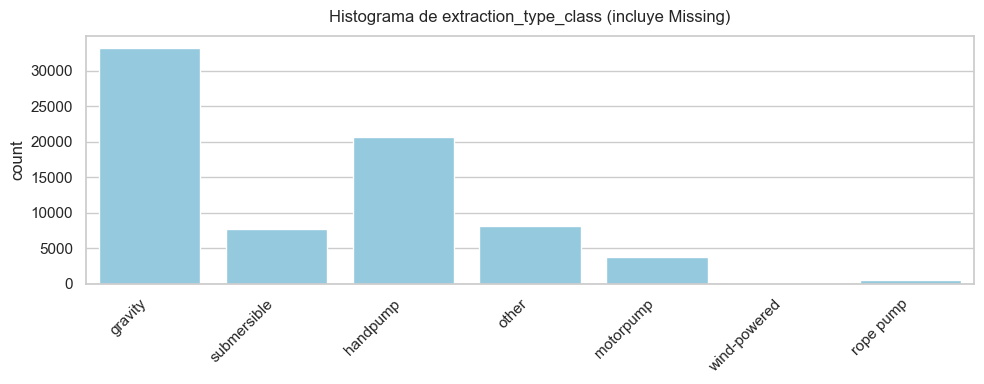

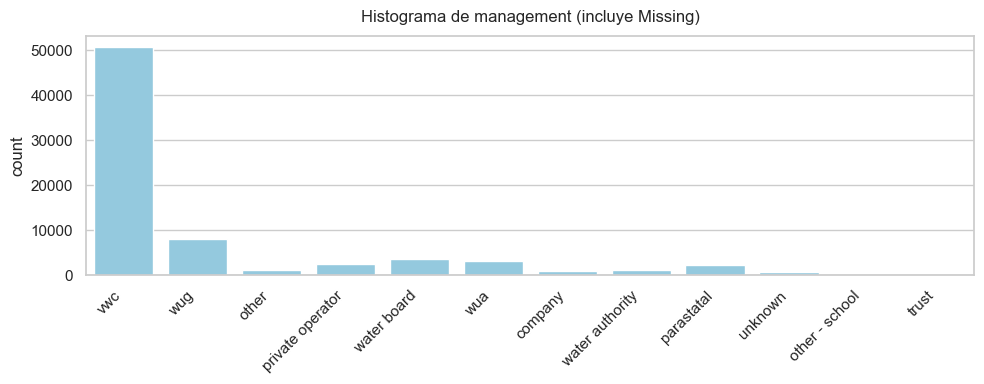

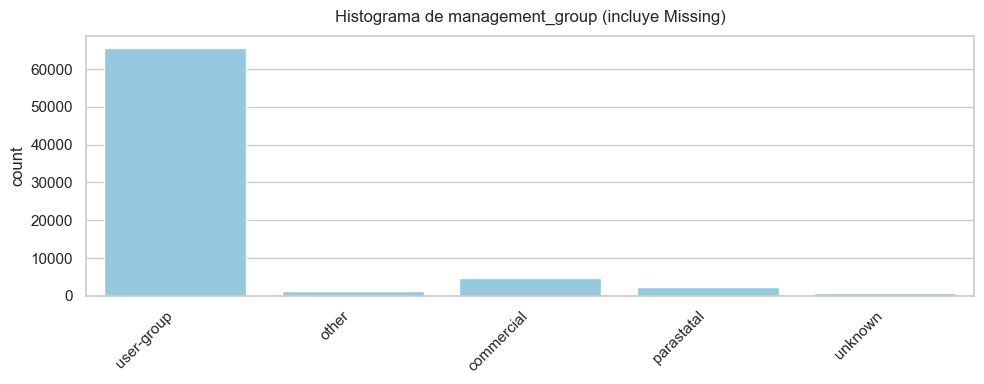

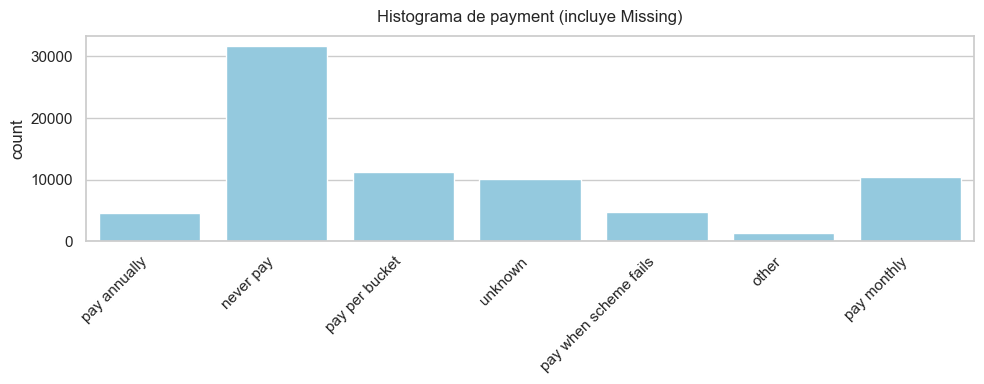

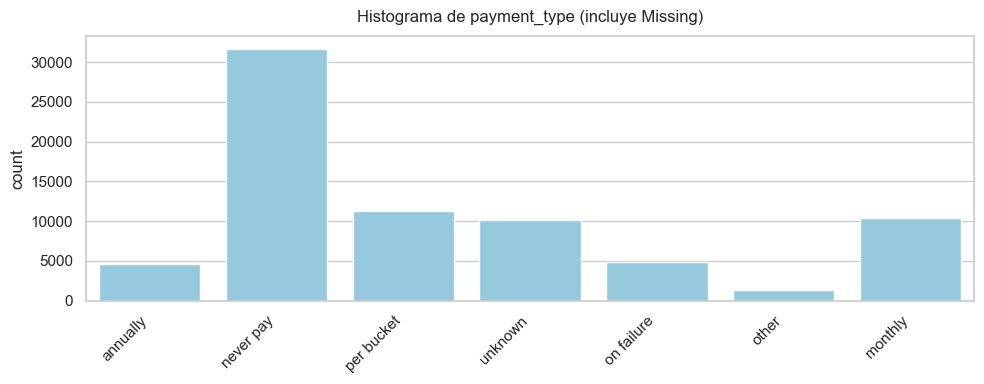

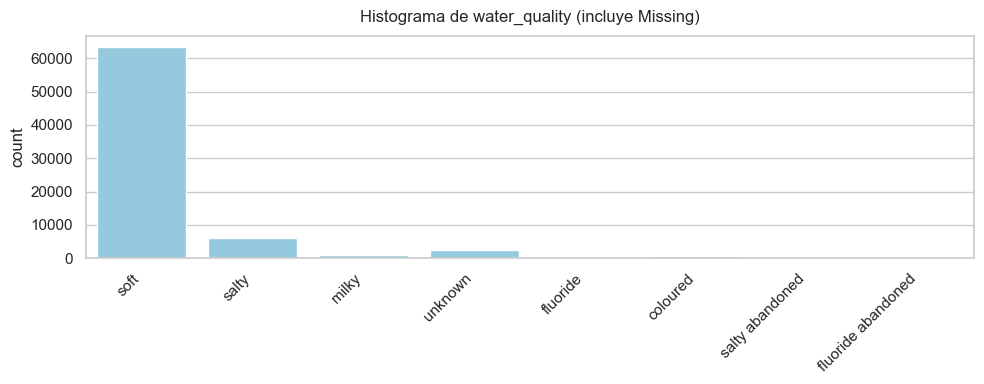

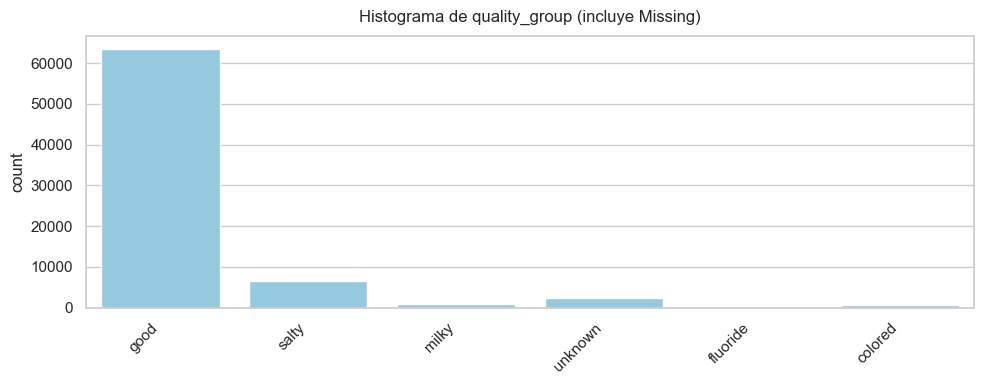

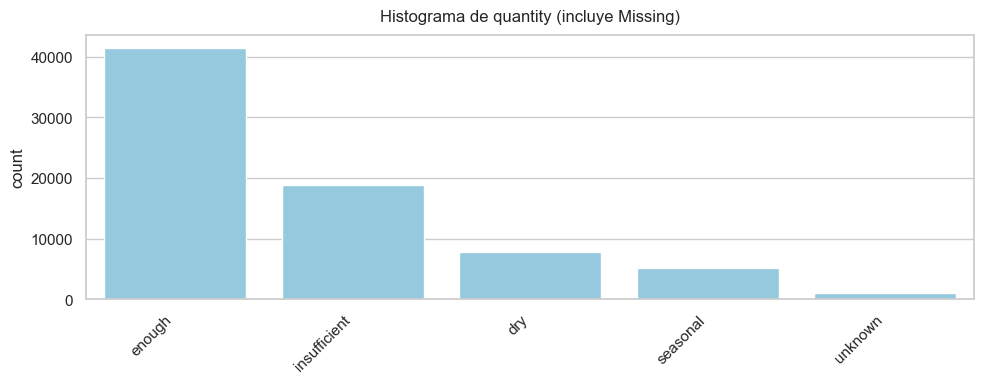

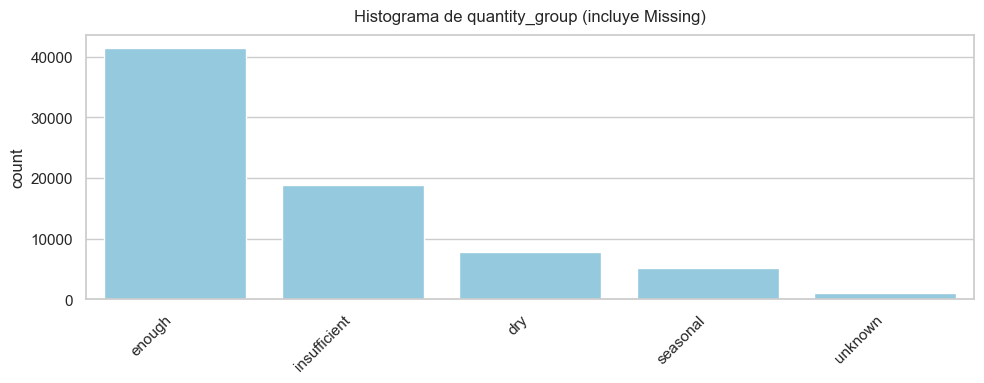

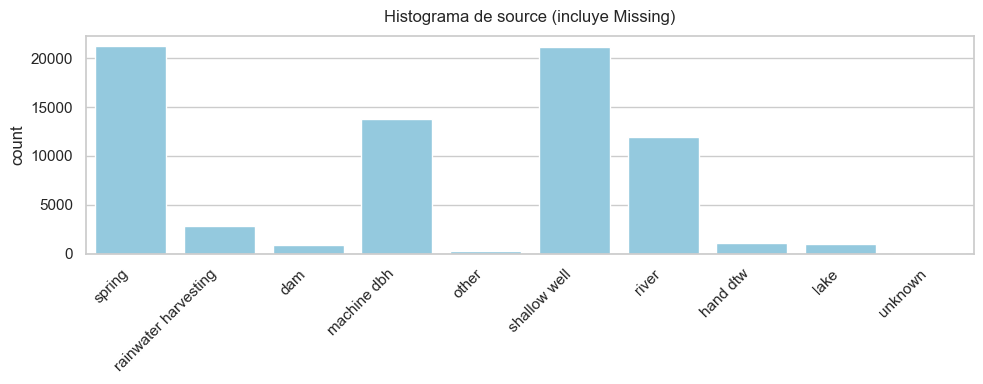

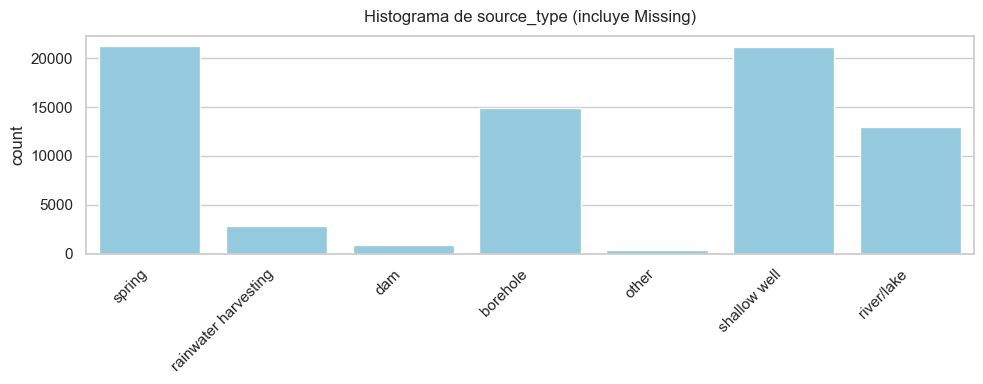

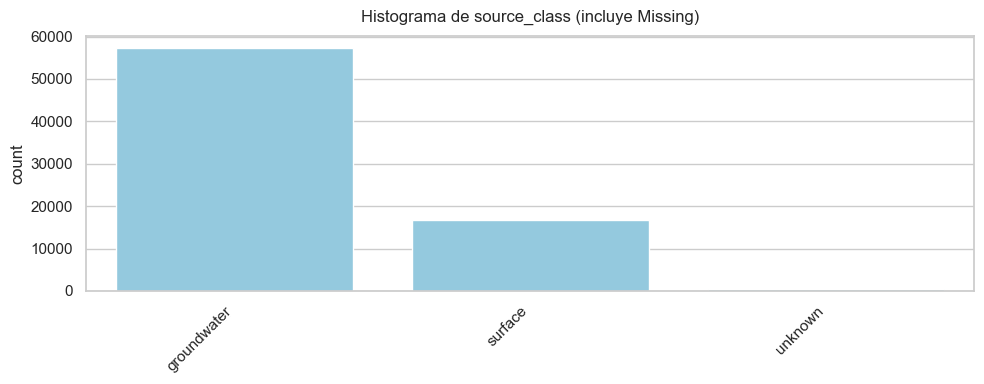

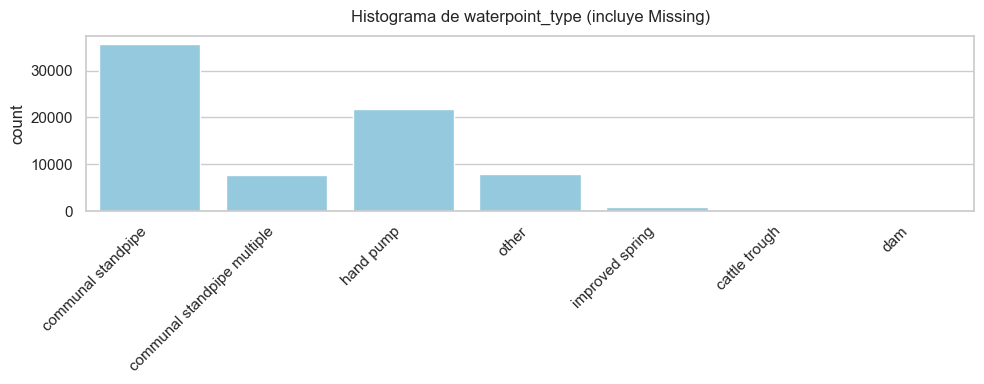

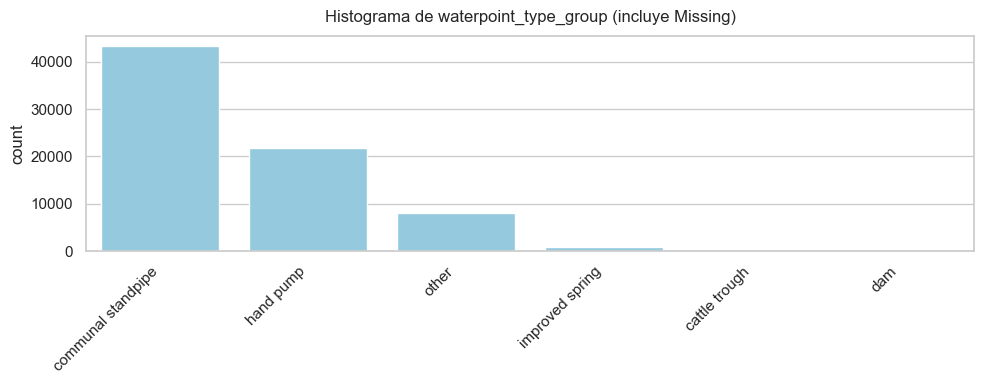

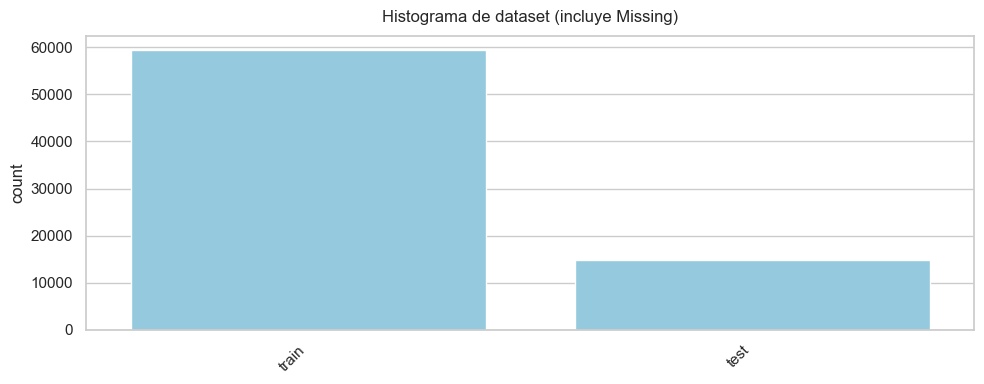

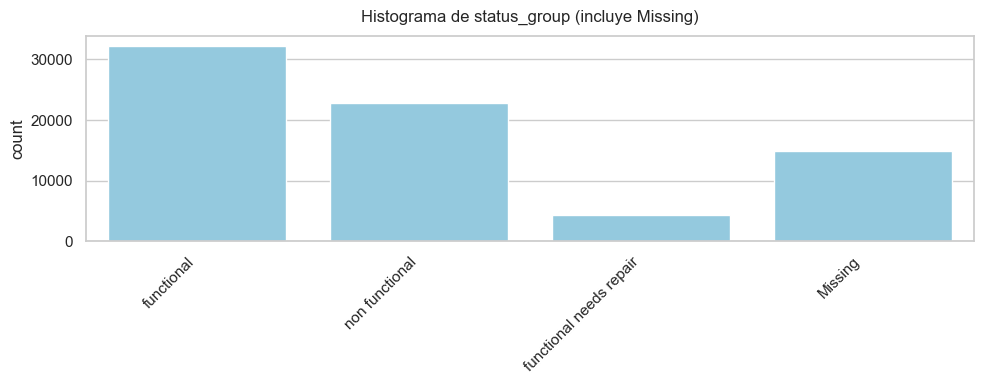

In [40]:
# Resetear índice para evitar errores
df_final = df_final.reset_index(drop=True)

# Estilo general
sns.set(style="whitegrid")

for var in low_cardinality_vars:
    plt.figure(figsize=(10, 4))
    
    # Reemplazar temporalmente NaN por 'Missing' para esta variable
    temp_series = df_final[var].fillna('Missing')
    
    sns.countplot(x=temp_series, color="skyblue")
    
    plt.title(f'Histograma de {var} (incluye Missing)', fontsize=12, pad=10)
    plt.xlabel('')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



### Principales hallazgos y decisiones aplicadas  

| Hallazgo | Evidencia vista en los gráficos | Decisión implementada |
|----------|---------------------------------|--------------------------------------|
| `amount_tsh` y `population` muy sesgadas a la derecha | Boxplots con cola larga y puntos extremos | `log1p()` sobre `amount_tsh` (`amount_tsh_log`) y **binning** de `population` en categorías *rural / semi-urban / urban* (`population_bin`) |
| Altura GPS (`gps_height`) con rango amplio pero sin valores aberrantes | Distribución relativamente compacta | Mantener numérica y escalar con `StandardScaler` dentro del `ColumnTransformer` |
| **Códigos geográficos** (`region_code`, `district_code`) y **variables de texto** con cientos de valores | Barras inferiores al 1 % de los registros | Agrupar etiquetas infrecuentes con `RareLabelEncoder(threshold = 0.01)` |
| Dominio claro de la categoría **“gravity”** en los tres `extraction_type*` | > 30 k registros frente a 1-5 k del resto | Conservar tal cual; codificar con One-Hot (el modelo maneja el desbalance) |
| Campos booleanos con nulos (`public_meeting`, `permit`) | Presencia explícita de “Missing” en histos | Mapear a la categoría **`'Unknown'`** (`*_cat` variables) antes de One-Hot |
| Bombas muy antiguas concentran fallos | `construction_year` < 1980 casi siempre no funcional | Nueva variable binaria `is_old_construction` |

> **Resultado:** las numéricas quedan sin sesgos extremos, las categóricas con cardinalidad controlada y los nulos convertidos en información útil. Todo esto se encapsula en el `Pipeline` (`preprocessor` + `XGBClassifier`) que ya entrenas a partir de la celda 136.


## Aplicación de correcciones a las variables numéricas

En este apartado se aplican las primeras correcciones básicas sobre las variables numéricas del conjunto de datos. El objetivo es detectar y corregir errores evidentes en los datos, como valores imposibles o codificaciones incorrectas

In [41]:
df_final['gps_height'] = df_final['gps_height'].apply(lambda x: np.nan if x<0 else x)
df_final['longitude'] = df_final['longitude'].apply(lambda x: np.nan if x==0 else x)
df_final['region_code'] = df_final['region_code'].astype('object')
df_final['district_code'] = df_final['district_code'].astype('object')
df_final['construction_year'] = df_final['construction_year'].apply(lambda x: np.nan if x==0 else x)

- `gps_height`: Los valores negativos no tienen sentido geográfico en Tanzania, por lo que se han reemplazado por valores nulos (`NaN`).
- `longitude`: Un valor de longitud igual a 0 es inválido en este contexto y se ha tratado como valor nulo (`NaN`).
- `construction_year`: El año de construcción igual a 0 indica falta de información, por lo que también se ha convertido en valor nulo (`NaN`).
- `region_code` y `district_code`: Aunque tienen formato numérico, representan códigos categóricos. Se han convertido a tipo `object` para tratarlos como variables categóricas en fases posteriores.

Estas correcciones permiten limpiar errores de origen en los datos sin eliminar información relevante, facilitando así un análisis más fiable en los siguientes pasos.

## Gestión de outliers

In [49]:
def gestiona_outliers(col, clas='check'):
    print(f'\nVariable: {col.name}')
    print('--------------------------------------')

    # Criterio 1 basado en asimetría
    if abs(col.skew()) < 1:
        criterio1 = abs((col - col.mean()) / col.std()) > 3
    else:
        criterio1 = abs((col - col.median()) / stats.median_abs_deviation(col)) > 8

    # Criterio 2 basado en IQR
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    criterio2 = (col < (q1 - 3 * iqr)) | (col > (q3 + 3 * iqr))

    # Combinación de criterios
    lower = col[criterio1 & criterio2 & (col < q1)].count() / col.dropna().count()
    upper = col[criterio1 & criterio2 & (col > q3)].count() / col.dropna().count()

    if clas == 'check':
        print(f'Outliers bajos (<Q1-3×IQR): {lower*100:.2f}%')
        print(f'Outliers altos (>Q3+3×IQR): {upper*100:.2f}%')
        print(f'Total de outliers detectados: {(lower+upper)*100:.2f}%')
        
    elif clas == 'winsor':
        return winsorize_with_pandas(col, (lower, upper))

    elif clas == 'miss':
        print(f'\nMissing antes: {col.isna().sum()}')
        col.loc[criterio1 & criterio2] = np.nan
        print(f'Missing después: {col.isna().sum()}')
        return col


In [50]:
gestiona_outliers(df_final['amount_tsh'], clas='check')


Variable: amount_tsh
--------------------------------------
Outliers bajos (<Q1-3×IQR): 0.00%
Outliers altos (>Q3+3×IQR): 18.75%
Total de outliers detectados: 18.75%


In [51]:
gestiona_outliers(df_final['population'], clas='check')


Variable: population
--------------------------------------
Outliers bajos (<Q1-3×IQR): 0.00%
Outliers altos (>Q3+3×IQR): 3.33%
Total de outliers detectados: 3.33%


In [53]:
df_final['amount_tsh_log'] = np.log1p(df_final['amount_tsh'])

Se ha analizado la presencia de valores extremos en las variables numéricas mediante una combinación de criterios robustos basados en la asimetría de la variable y su dispersión respecto al IQR. A partir de este análisis, se han tomado las siguientes decisiones:

- `amount_tsh`: presenta un 18.75% de valores excepcionalmente altos. Debido a la magnitud de estos valores y su clara asimetría, se ha creado una transformación logarítmica (`log1p`) para suavizar su escala y reducir el impacto relativo de los valores extremos sin perder información.
  
- `population`: presenta un 3.33% de valores extremos. Dado que la proporción es baja y la variable tiene una interpretación directa, se ha decidido conservarla sin modificaciones para preservar su distribución original.

Estas transformaciones permiten mantener la información contenida en las variables al tiempo que se reducen los posibles efectos distorsionadores de los valores atípicos en fases posteriores del análisis.


## Análisis de incidencia de missings

### Identificamos que variables tienen missings

In [57]:
df_final.apply(lambda x: x.isna().sum()/df_final.shape[0]*100)

id                        0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    6.070034
gps_height                2.533333
installer                 6.103704
longitude                 3.055892
latitude                  0.000000
wpt_name                  0.002694
num_private               0.000000
basin                     0.000000
subvillage                0.632997
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.595960
recorded_by               0.000000
scheme_management         6.527946
scheme_name              48.554882
permit                    5.108418
construction_year        34.975084
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

### Analisis de la proporción de missings por registro

In [58]:
df_final['prop_missings'] = df_final.apply(lambda x: x.isna().sum()/df_final.shape[1]*100, axis=1)
df_final.prop_missings.describe()

count    74250.000000
mean         3.236301
std          2.902138
min          0.000000
25%          0.000000
50%          2.325581
75%          4.651163
max         18.604651
Name: prop_missings, dtype: float64

In [60]:
df_final.sort_values(by='prop_missings', ascending=False).head(25)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,dataset,status_group,amount_tsh_log,prop_missings
64979,67318,0.0,2013-03-11,NaN,1283.0,NaN,36.555235,-3.457174e+00,Bomba La Kijiji,0,...,unknown,unknown,other,unknown,communal standpipe,communal standpipe,test,NaN,0.0,18.604651
63832,28364,0.0,2013-03-19,NaN,989.0,NaN,36.962775,-3.426325e+00,Mzee Msafi,0,...,unknown,unknown,other,unknown,communal standpipe,communal standpipe,test,NaN,0.0,18.604651
25463,9846,0.0,2012-10-30,NaN,0.0,NaN,NaN,-2.000000e-08,none,0,...,unknown,shallow well,shallow well,groundwater,hand pump,hand pump,train,functional needs repair,0.0,16.279070
59505,17873,0.0,2012-10-19,NaN,0.0,NaN,32.305549,-3.508052e+00,Mponda,0,...,unknown,unknown,other,unknown,hand pump,hand pump,test,NaN,0.0,16.279070
59344,6450,0.0,2013-10-03,NaN,1303.0,NaN,36.900911,-3.111477e+00,Pentecoste Swidish,0,...,unknown,spring,spring,groundwater,communal standpipe,communal standpipe,train,functional,0.0,16.279070
36032,66687,0.0,2013-10-03,NaN,1304.0,NaN,36.900464,-3.112022e+00,Zahanati Ngabobo,0,...,unknown,spring,spring,groundwater,communal standpipe,communal standpipe,train,functional,0.0,16.279070
54290,58037,0.0,2013-03-03,NaN,0.0,NaN,NaN,-2.000000e-08,No 3,0,...,unknown,unknown,other,unknown,hand pump,hand pump,train,non functional,0.0,16.279070
21690,71282,0.0,2013-03-19,NaN,1289.0,NaN,36.189340,-3.422393e+00,Mongoriondo,0,...,unknown,unknown,other,unknown,communal standpipe,communal standpipe,train,functional,0.0,16.279070
27798,65087,0.0,2013-03-19,NaN,1143.0,NaN,36.320944,-2.823900e+00,Madukani,7,...,unknown,unknown,other,unknown,hand pump,hand pump,train,functional,0.0,16.279070
70222,34155,0.0,2012-10-04,NaN,0.0,NaN,32.737229,-3.390726e+00,Namba Tano,0,...,unknown,unknown,other,unknown,hand pump,hand pump,test,NaN,0.0,16.279070


<Axes: >

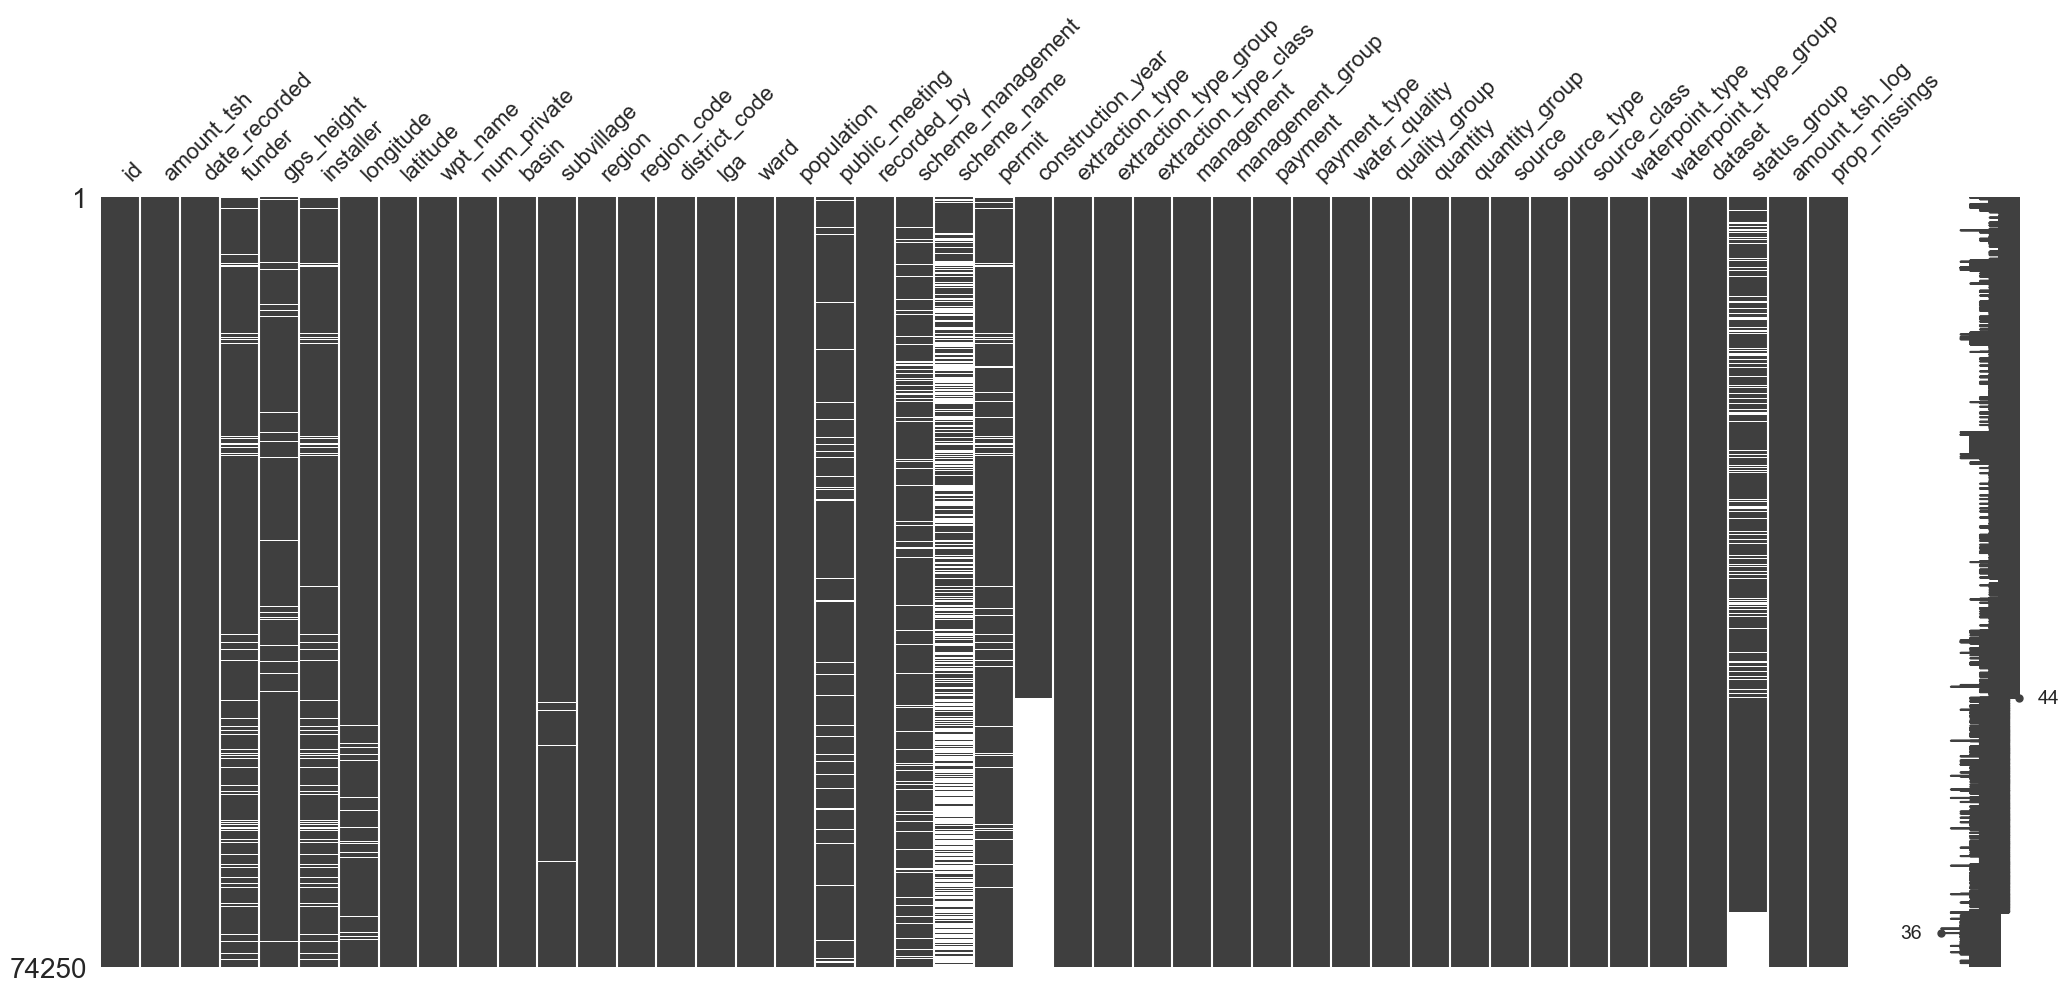

In [61]:
msno.matrix(df_final.sort_values(by='construction_year'))

<Axes: >

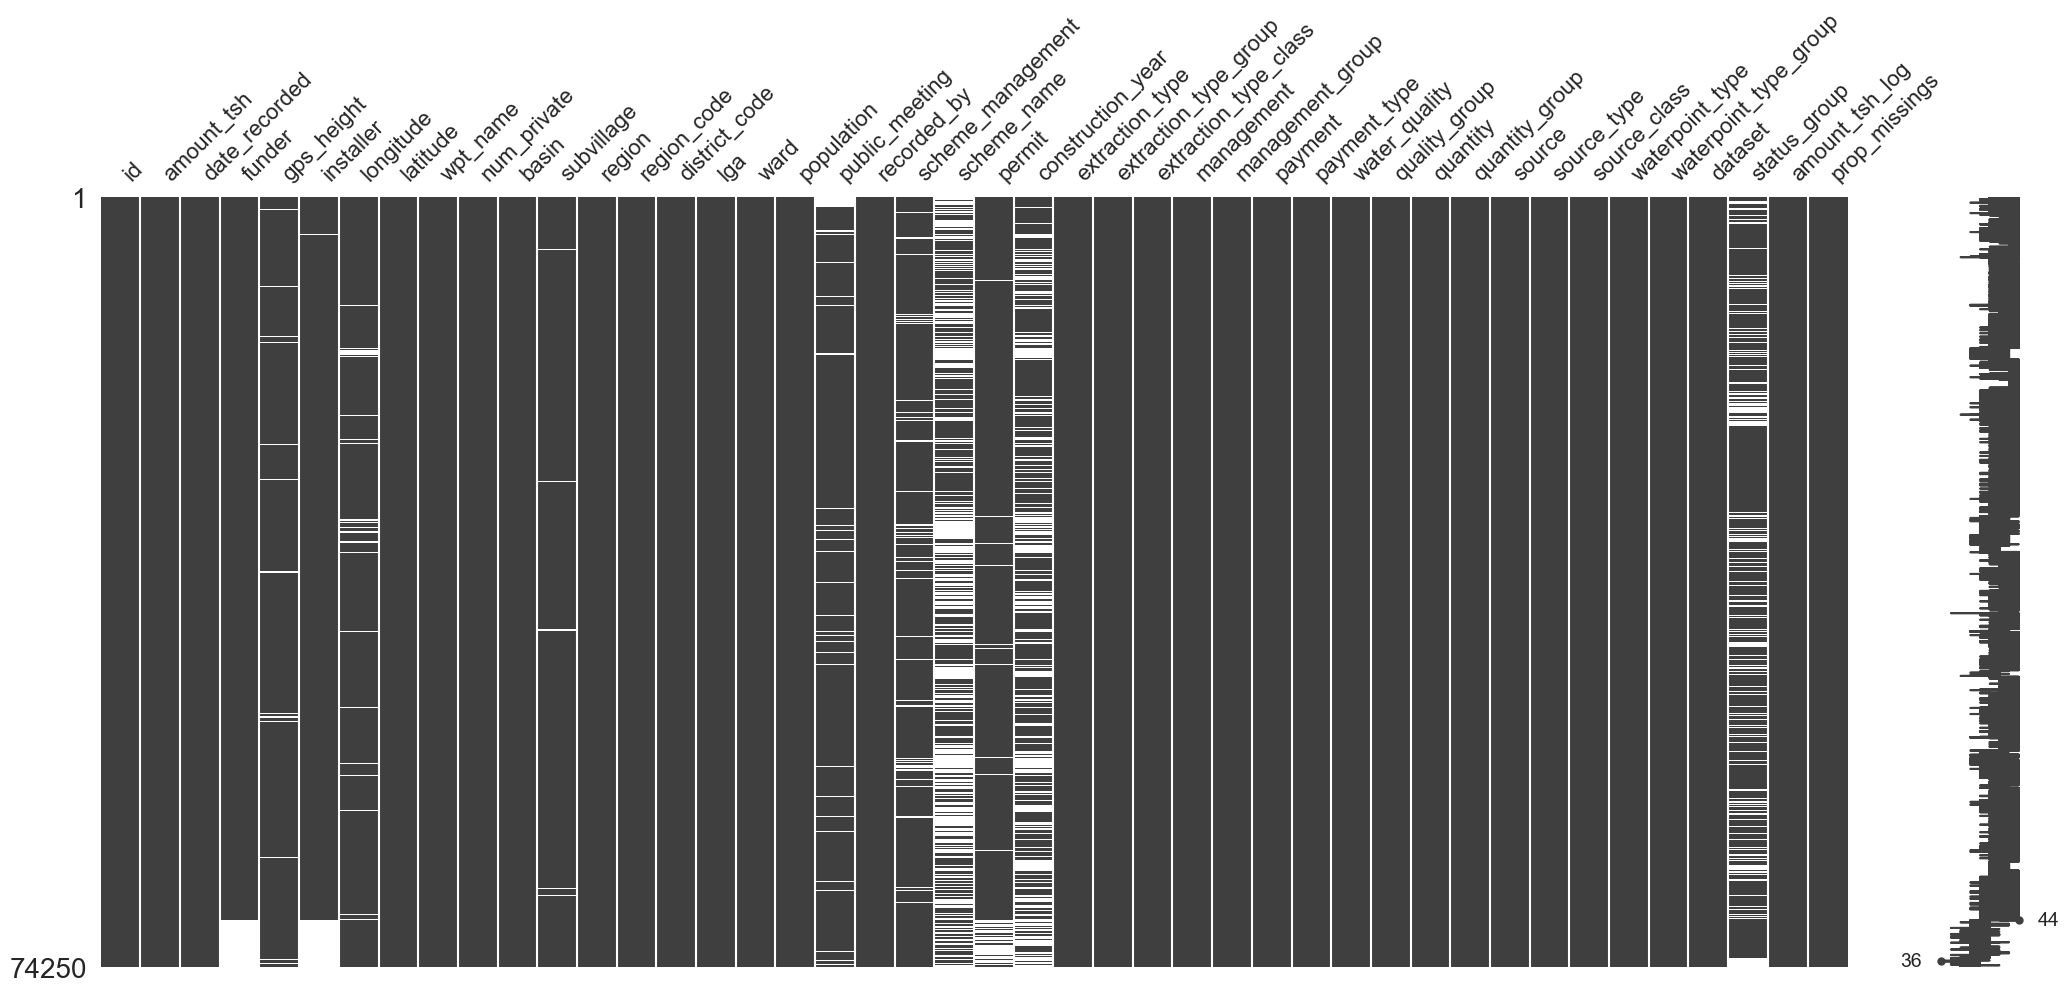

In [63]:
msno.matrix(df_final.sort_values(by='funder'))

Antes de imputar los valores `NaN` del conjunto de datos, se ha realizado una exploración visual con una matriz de missingness (`msno.matrix`). Esta herramienta permite observar tanto la distribución de los valores faltantes en las columnas como su concentración por registros individuales.
Se han generado dos visualizaciones clave:
- Una centrada en la variable `construction_year`, donde se observa que su ausencia suele coincidir con otros campos administrativos incompletos.
- Otra centrada en la variable `funder`, que revela una fuerte presencia de valores faltantes, generalmente acompañada de nulos en `installer`.

Estas visualizaciones permiten identificar patrones de co-ocurrencia de datos ausentes, lo cual es esencial para decidir una estrategia de imputación coherente.  
A continuación, se abordará el tratamiento de los valores faltantes en función del tipo de variable y del contexto en que aparecen.


### Tratamiento de valores missing

In [65]:
#Los missing de estas variables son correlados así que los tratamos juntos
df_final['funder'] = df_final['funder'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_final['installer'] = df_final['installer'].apply(lambda x: 'Unknown' if pd.isna(x) else x)


In [ ]:
#Doble estrategia 
#Mantenemos los Missing como una nueva categoría
df_final['public_meeting_cat'] = df_final['public_meeting'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_final['permit_cat'] = df_final['permit'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_final['scheme_management_cat'] = df_final['scheme_management'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_final['subvillage_cat'] = df_final['subvillage'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
#Imputamos por moda
imputer_moda = skl_imp.SimpleImputer(strategy='most_frequent', missing_values=np.nan)

df_final['public_meeting_imp'] = imputer_moda.fit_transform(df_final[['public_meeting']]).ravel()
df_final['permit_imp'] = imputer_moda.fit_transform(df_final[['permit']]).ravel()
df_final['scheme_management_imp'] = imputer_moda.fit_transform(df_final[['scheme_management']]).ravel()
df_final['subvillage_imp'] = imputer_moda.fit_transform(df_final[['subvillage']]).ravel()

# Eliminamos las columnas originales
df_final.drop(columns=['public_meeting', 'permit', 'scheme_management', 'subvillage'], inplace=True)


In [71]:
df_final = df_final.drop('scheme_name', axis=1)

In [87]:
df_final['public_meeting_cat'] = df_final['public_meeting_cat'].astype(str)
df_final['permit_cat'] = df_final['permit_cat'].astype(str)
df_final['scheme_management_cat'] = df_final['scheme_management_cat'].astype(str)
df_final['subvillage_cat'] = df_final['subvillage_cat'].astype(str)


## Tratamiento de valores faltantes en variables categóricas y booleanas

Se ha aplicado una doble estrategia de tratamiento de valores faltantes en las variables categóricas y booleanas que presentaban missing:

- **Para las variables `funder` e `installer`**, cuyos valores faltantes mostraban alta correlación, se imputaron los `NaN` asignándoles directamente la categoría `"Unknown"`, manteniendo así la coherencia entre ambas variables.

- **Para las variables `public_meeting`, `permit`, `scheme_management` y `subvillage`**, se diseñaron dos versiones de cada variable:
  - Una versión donde los valores faltantes se imputaron creando una nueva categoría explícita denominada `"Unknown"`, permitiendo que los modelos traten la ausencia de información como una categoría diferenciada (`_cat`).
  - Una segunda versión donde los valores faltantes se imputaron utilizando la moda de cada variable (`_imp`), manteniendo la distribución original de los datos.

- **La variable `scheme_name`**, con más de un 48% de valores faltantes, se ha eliminado del dataset debido a la falta de completitud y al bajo valor que podría aportar.

Con este planteamiento, se preserva la mayor cantidad de información posible y se habilita la posibilidad de comparar el rendimiento de diferentes estrategias de imputación en el modelado posterior.


In [72]:
# 1. Imputar gps_height usando la mediana de lga
df_final['gps_height_imp'] = df_final['gps_height']

for lga in df_final['lga'].unique():
    mediana = df_final.loc[df_final['lga'] == lga, 'gps_height'].median()
    df_final.loc[(df_final['gps_height_imp'].isna()) & (df_final['lga'] == lga), 'gps_height_imp'] = mediana

# 2. Imputar longitude con mediana global
mediana_longitude = df_final['longitude'].median()
df_final['longitude_imp'] = df_final['longitude'].fillna(mediana_longitude)

# 3. Crear variable has_construction_info (1 si tiene año de construcción, 0 si no)
df_final['has_construction_info'] = df_final['construction_year'].notna().astype(int)


## Tratamiento de valores faltantes en variables numéricas

En esta fase se han tratado los valores `NaN` de las variables numéricas siguiendo criterios que permiten conservar la información geográfica y temporal más relevante:

- **gps_height**: se ha imputado el valor faltante utilizando la mediana dentro de cada `lga` (Local Government Area), aprovechando la alta granularidad de esta variable para obtener una imputación más precisa y localizada.

- **longitude**: se ha imputado mediante la mediana global del dataset, dado que su porcentaje de valores faltantes es reducido y su distribución no presenta anomalías significativas.

- **construction_year**: dada la elevada proporción de valores faltantes (~35%), se ha creado una nueva variable binaria `has_construction_info` que indica si se dispone o no de información sobre el año de construcción. Esta estrategia permite que los modelos futuros utilicen la ausencia de información como una posible señal predictiva.




In [ ]:
df_final.drop(columns=['gps_height', 'longitude', 'prop_missings', 'wpt_name'], inplace=True)


In [85]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     74250 non-null  int64         
 1   amount_tsh             74250 non-null  float64       
 2   date_recorded          74250 non-null  datetime64[ns]
 3   funder                 74250 non-null  object        
 4   installer              74250 non-null  object        
 5   latitude               74250 non-null  float64       
 6   num_private            74250 non-null  int64         
 7   basin                  74250 non-null  object        
 8   region                 74250 non-null  object        
 9   region_code            74250 non-null  object        
 10  district_code          74250 non-null  object        
 11  lga                    74250 non-null  object        
 12  ward                   74250 non-null  object        
 13  p

## Guardado del dataset.
df_unido_limpio.parquet → Dataset final tras limpieza de missing, outliers y tratamiento básico de variables. Listo para feature engineering.


In [88]:
df_final.to_parquet('df_unido_limpio.parquet')

# Feature engineering

## Feature engineering
El modelo final no solo depende de los algoritmos, sino de **cómo representamos el problema en variables**. En esta sección creamos nuevas variables que capturan relaciones no lineales, interacciones y conocimiento de dominio (por ejemplo, la antigüedad real de la bomba en años). Cada transformación se diseña para añadir información predictiva sin inflar innecesariamente la dimensionalidad.

In [92]:
df_final = pd.read_parquet('df_unido_limpio.parquet')

In [94]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     74250 non-null  int64         
 1   amount_tsh             74250 non-null  float64       
 2   date_recorded          74250 non-null  datetime64[ns]
 3   funder                 74250 non-null  object        
 4   installer              74250 non-null  object        
 5   latitude               74250 non-null  float64       
 6   num_private            74250 non-null  int64         
 7   basin                  74250 non-null  object        
 8   region                 74250 non-null  object        
 9   region_code            74250 non-null  int64         
 10  district_code          74250 non-null  int64         
 11  lga                    74250 non-null  object        
 12  ward                   74250 non-null  object        
 13  p

## Creación de nuevas variables derivadas

In [102]:
# VARIABLES TEMPORALES
# Año de registro
df_final['year_recorded'] = df_final['date_recorded'].dt.year
# Mes de registro
df_final['month_recorded'] = df_final['date_recorded'].dt.month
# Trimestre de registro
df_final['recorded_quarter'] = df_final['date_recorded'].dt.quarter
# Edad del pozo
# Para posibles valores negativos: si la fecha de construcción es después del registro (datos erróneos).
df_final['age'] = df_final['year_recorded'] - df_final['construction_year']
df_final['age'] = df_final['age'].apply(lambda x: np.nan if x < 0 else x)
# VARIABLES SOBRE CANTIDAD DE AGUA
#¿Pozo sin cantidad de agua (0)?
df_final['zero_amount_tsh'] = (df_final['amount_tsh'] == 0).astype(int)                                       

Se han generado nuevas variables a partir de las variables originales `date_recorded`, `construction_year` y `amount_tsh`, con el objetivo de capturar información temporal relevante y características físicas del pozo:

- A partir de `date_recorded`, se han extraído el año (`year_recorded`), el mes (`month_recorded`) y el trimestre (`recorded_quarter`) en que se registró el pozo, para identificar posibles patrones estacionales o tendencias temporales.
- Se ha calculado la edad de cada pozo (`age`) como la diferencia entre el año de registro y el año de construcción, marcando como `NaN` los casos en los que la edad resultase negativa, ya que indicarían inconsistencias en los datos originales.
- Se ha creado una variable binaria (`zero_amount_tsh`) que indica si el pozo presenta una cantidad de agua igual a cero, lo cual puede ser un fuerte indicador de un posible fallo o mal funcionamiento.

Estas nuevas variables permiten enriquecer el conjunto de datos con información derivada que podría ser determinante en la predicción del estado operativo de los pozos.

### Análisis de distributiones para definir umbrales

In [103]:
# Ver percentiles de amount_tsh
print("Percentiles de amount_tsh (cantidad de agua):")
print(df_final['amount_tsh'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99]))
# Ver percentiles de population
print("Percentiles de population (población alrededor del pozo):")
print(df_final['population'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99]))

Percentiles de amount_tsh (cantidad de agua):
count     74250.000000
mean        318.685704
std        2906.762364
min           0.000000
1%            0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%          20.000000
90%         500.000000
95%        1200.000000
99%        5000.000000
max      350000.000000
Name: amount_tsh, dtype: float64
Percentiles de population (población alrededor del pozo):
count    74250.000000
mean       180.750828
std        471.086120
min          0.000000
1%           0.000000
5%           0.000000
25%          0.000000
50%         25.000000
75%        215.000000
90%        455.000000
95%        690.000000
99%       2000.000000
max      30500.000000
Name: population, dtype: float64


### Análisis de percentiles para definir umbrales

Antes de crear variables derivadas adicionales basadas en cantidad de agua disponible y población, se realizó un análisis exploratorio de las distribuciones de `amount_tsh` y `population`.  
Se calcularon los principales percentiles (1%, 5%, 25%, 50%, 75%, 90%, 95% y 99%) para entender mejor el comportamiento de estas variables.

Este análisis permitió:
- Detectar que una gran parte de los pozos presentan valores bajos de `amount_tsh`, lo que justifica definir un umbral para considerar "baja cantidad de agua".
- Observar que la mayoría de los pozos se encuentran en áreas de baja densidad de población, permitiendo establecer cortes informados para clasificar las zonas como rurales, semiurbanas o urbanas.

Basar la definición de nuevas variables en percentiles reales garantiza que las transformaciones respeten la estructura de los datos y mejoren la calidad del modelado posterior.


In [104]:
# Variable para detectar poca cantidad de agua
df_final['low_amount_tsh'] = (df_final['amount_tsh'] < 500).astype(int)
# Variable para clasificar la zona según la población
# Basado en percentiles analizados:
# rural: <= 50 habitantes | semiurban: entre 50 y 500 | urban: > 500
df_final['population_bin'] = pd.cut(
    df_final['population'],
    bins=[-1, 50, 500, np.inf],
    labels=['rural', 'semiurban', 'urban']
)

### Creación de variables basadas en umbrales

Basándose en el análisis de los percentiles anteriores, se han generado dos nuevas variables:
- `low_amount_tsh`: variable binaria que toma el valor 1 si la cantidad de agua disponible en el pozo es inferior a 500 unidades, y 0 en caso contrario. Este umbral se seleccionó al observar que hasta el percentil 90 los valores de `amount_tsh` eran inferiores a 500.
- `population_bin`: variable categórica que clasifica el área donde se encuentra el pozo en función del número de habitantes:
  - `rural`: hasta 50 habitantes
  - `semiurban`: entre 51 y 500 habitantes
  - `urban`: más de 500 habitantes
Estos cortes permiten capturar de forma simplificada las diferencias contextuales entre áreas rurales, semiurbanas y urbanas, mejorando la capacidad predictiva de los modelos sobre el estado de los pozos.


In [105]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     74250 non-null  int64         
 1   amount_tsh             74250 non-null  float64       
 2   date_recorded          74250 non-null  datetime64[ns]
 3   funder                 74250 non-null  object        
 4   installer              74250 non-null  object        
 5   latitude               74250 non-null  float64       
 6   num_private            74250 non-null  int64         
 7   basin                  74250 non-null  object        
 8   region                 74250 non-null  object        
 9   region_code            74250 non-null  int64         
 10  district_code          74250 non-null  int64         
 11  lga                    74250 non-null  object        
 12  ward                   74250 non-null  object        
 13  p

## Trabajo con variables categóricas

In [113]:
var_categoric = df_final.select_dtypes(include=['object', 'category']).columns.tolist()

In [114]:
for num in var_categoric:
    print(f'{num}: {df_final[num].nunique()}')

funder: 2139
installer: 2410
basin: 9
region: 21
lga: 125
ward: 2098
extraction_type: 18
extraction_type_group: 13
extraction_type_class: 7
management: 12
management_group: 5
payment: 7
payment_type: 7
water_quality: 8
quality_group: 6
quantity: 5
quantity_group: 5
source: 10
source_type: 7
source_class: 3
waterpoint_type: 7
waterpoint_type_group: 6
dataset: 2
status_group: 3
public_meeting_cat: 3
permit_cat: 3
scheme_management_cat: 12
subvillage_cat: 21426
scheme_management_imp: 11
subvillage_imp: 21425
population_bin: 3


In [ ]:
df_final.drop('recorded_by', axis=1, inplace=True)

In [ ]:
df_final.drop(columns=['date_recorded'], inplace=True)

In [17]:
# Baja cardinalidad (≤ 10 categorías) → One-Hot Encoding
one_hot_vars = [
    'basin', 'management_group', 'payment', 'payment_type',
    'quantity', 'quantity_group', 'source_class',
    'waterpoint_type_group',
    'public_meeting_cat', 'permit_cat', 'population_bin',
    'quality_group', 'water_quality', 'waterpoint_type'
]
# Alta cardinalidad (agrupadas) → RareLabelEncoder o TargetEncoder
high_card_vars = [
    'funder', 'installer', 'ward', 'lga',
    'subvillage_cat', 'subvillage_imp'
]
# Cardinalidad media (entre 11 y 100) → Label Encoding o One-Hot según prueba
medium_card_vars = [
    'region', 'management', 'source', 'extraction_type',
    'extraction_type_group', 'extraction_type_class',
    'scheme_management_cat', 'scheme_management_imp',
    'source_type', 'region_code', 'district_code'
]
# Binarias o booleanas (0/1 o True/False) → Label Encoding
binary_vars = [
    'has_construction_info',
    'zero_amount_tsh',
    'low_amount_tsh',
    'public_meeting_imp',
    'permit_imp'
]
num_vars = [
    'amount_tsh_log', 'gps_height_imp', 'longitude_imp', 'latitude',
    'age', 'population', 'year_recorded', 'month_recorded', 'recorded_quarter'
]


## Clasificación de variables categóricas según su cardinalidad

Para preparar correctamente el preprocesamiento de los datos antes del modelado, se ha realizado una clasificación de las variables categóricas en función de su cardinalidad, es decir, del número de categorías distintas que presenta cada una. Esta clasificación permite aplicar estrategias de codificación más adecuadas a cada grupo, optimizando tanto el rendimiento como la interpretabilidad de los modelos.

Las variables categóricas se han agrupado en los siguientes bloques:

- **Variables de baja cardinalidad (≤ 10 categorías)**: son candidatas ideales para aplicar *One-Hot Encoding*, ya que el número de columnas generadas es manejable y no genera una explosión de dimensionalidad.
  
- **Variables de alta cardinalidad**: presentan cientos o miles de categorías, lo que imposibilita una codificación directa sin provocar problemas de sobreajuste. Estas variables se tratarán mediante técnicas específicas como agrupación de rarezas (`RareLabelEncoder`) y codificación supervisada (`Target Encoding`).
  
- **Variables de cardinalidad media (entre 11 y 100 categorías)**: se evaluarán caso por caso, pudiendo aplicar *Label Encoding* o *One-Hot Encoding* en función del impacto en el modelo.
  
- **Variables binarias o booleanas**: variables con solo dos categorías, que se codificarán directamente mediante *Label Encoding* (0/1).

Esta separación permitirá construir un pipeline de transformación flexible y eficiente, adaptado a las características específicas de cada variable.

# Modelado

## Separación de datasets. 

In [117]:
# Codificar la variable objetivo
df_final['status_group_num'] = df_final['status_group'].map({
    'functional': 2,
    'functional needs repair': 1,
    'non functional': 0
})

# Separar en train y test usando la columna 'dataset'
df_train = df_final[df_final['dataset'] == 'train'].copy()
df_test = df_final[df_final['dataset'] == 'test'].copy()

# Extraer y_train desde df_train
y_train = df_train['status_group_num'].copy()

# Establecer el índice como 'id' antes de eliminarlo
df_train.set_index('id', inplace=True)
df_test.set_index('id', inplace=True)
y_train.index = df_train.index  # Aseguramos que tengan el mismo índice

# Eliminar columnas innecesarias de los datasets de features
cols_to_drop = ['status_group', 'status_group_num', 'dataset']
X_train = df_train.drop(columns=cols_to_drop)
X_test = df_test.drop(columns=cols_to_drop)

# Guardar como Parquet
X_train.to_parquet('X_train_preparado.parquet')
y_train.to_frame(name='status_group_num').to_parquet('y_train.parquet')
X_test.to_parquet('X_test_preparado.parquet')


In [21]:
X_full = pd.read_parquet('X_train_preparado.parquet')
y_full = pd.read_parquet('y_train.parquet').squeeze()

In [22]:
df_full = X_full.join(y_full)

In [23]:
df_full

,amount_tsh,funder,installer,latitude,num_private,basin,region,region_code,district_code,lga,...,longitude_imp,has_construction_info,low_amount_tsh,population_bin,year_recorded,month_recorded,recorded_quarter,age,zero_amount_tsh,status_group_num
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,Roman,-9.856322,0,Lake Nyasa,Iringa,11,5,Ludewa,...,34.938093,1,0,semiurban,2011,3,1,12.0,0,2.0
8776,0.0,Grumeti,GRUMETI,-2.147466,0,Lake Victoria,Mara,20,2,Serengeti,...,34.698766,1,1,semiurban,2013,3,1,3.0,1,2.0
34310,25.0,Lottery Club,World vision,-3.821329,0,Pangani,Manyara,21,4,Simanjiro,...,37.460664,1,1,semiurban,2013,2,1,4.0,0,2.0
67743,0.0,Unicef,UNICEF,-11.155298,0,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,...,38.486161,1,1,semiurban,2013,1,1,27.0,1,0.0
19728,0.0,Action In A,Artisan,-1.825359,0,Lake Victoria,Kagera,18,1,Karagwe,...,31.130847,0,1,rural,2011,7,3,NaN,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10.0,Germany Republi,CES,-3.253847,0,Pangani,Kilimanjaro,3,5,Hai,...,37.169807,1,1,semiurban,2013,5,2,14.0,0,2.0
27263,4700.0,Cefa-njombe,Cefa,-9.070629,0,Rufiji,Iringa,11,4,Njombe,...,35.249991,1,0,semiurban,2011,5,2,15.0,0,2.0
37057,0.0,Unknown,Unknown,-8.750434,0,Rufiji,Mbeya,12,7,Mbarali,...,34.017087,0,1,rural,2011,4,2,NaN,1,2.0


In [24]:
df_full.columns

Index(['amount_tsh', 'funder', 'installer', 'latitude', 'num_private', 'basin',
       'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'amount_tsh_log',
       'public_meeting_cat', 'permit_cat', 'scheme_management_cat',
       'subvillage_cat', 'public_meeting_imp', 'permit_imp',
       'scheme_management_imp', 'subvillage_imp', 'gps_height_imp',
       'longitude_imp', 'has_construction_info', 'low_amount_tsh',
       'population_bin', 'year_recorded', 'month_recorded', 'recorded_quarter',
       'age', 'zero_amount_tsh', 'status_group_num'],
      dtype='object')

In [25]:
df_full.drop(columns=['amount_tsh', 'num_private', 'construction_year'], inplace=True)


## Construcción de los modelos de clasificación básicos.

Con el conjunto de datos ya preparado y las variables categóricas clasificadas por su cardinalidad, comenzamos la fase de **modelado inicial**. Esta etapa tiene como objetivo entrenar los **primeros modelos base de clasificación multiclase**, que nos servirán como punto de partida para futuras optimizaciones más avanzadas.
En esta fase, se construirán modelos utilizando dos de los algoritmos más representativos y eficaces para problemas de clasificación:
- **Random Forest Classifier**  
- **XGBoost Classifier**

Ambos algoritmos se entrenarán bajo dos enfoques distintos de codificación para variables categóricas de **alta cardinalidad**. Esto nos permitirá evaluar cuál de las transformaciones ofrece un mejor desempeño en términos predictivos y estabilidad:
- **Rare Label Encoding + One-Hot Encoding**: consiste en agrupar las categorías menos frecuentes en una categoría genérica (`"Other"`), seguida de codificación *One-Hot*. Esta estrategia busca evitar la explosión de columnas manteniendo la interpretabilidad.
- **Target Encoding**: transforma cada categoría en un valor numérico basado en la media de la variable objetivo para esa categoría, aplicando *suavizado* para reducir el riesgo de *overfitting*. Es una técnica supervisada que puede ofrecer ventajas significativas en modelos potentes como XGBoost.
- 
Cada combinación de algoritmo y codificación será evaluada mediante **validación cruzada estratificada**, garantizando una comparación justa y robusta. Además, todos los resultados obtenidos (métricas, hiperparámetros, variables utilizadas y modelos entrenados) serán registrados automáticamente mediante **MLflow**, lo que facilitará el seguimiento, la trazabilidad y la comparación entre experimentos.
Una vez finalizada esta fase, se analizarán y compararán los resultados para identificar qué combinación de modelo y codificación ofrece el mejor rendimiento. Este análisis guiará las siguientes fases del proyecto: **selección de variables**, **ajuste de hiperparámetros** y **construcción del modelo final**.

In [26]:
class RareLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, threshold=0.01):
        self.variables = variables
        self.threshold = threshold
        self.frequent_labels_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for var in self.variables:
            freq = X[var].value_counts(normalize=True)
            self.frequent_labels_[var] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.variables:
            X[var] = X[var].apply(
                lambda x: x if x in self.frequent_labels_[var] else 'Other'
            )
        return X

In [27]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, min_samples_leaf=1, smoothing=1):
        self.variables = variables
        self.min_samples_leaf = min_samples_leaf
        self.smoothing = smoothing
        self.encoding_maps_ = {}
        self.global_mean_ = None

    def fit(self, X, y):
        X = X.copy()
        y = pd.Series(y).copy()
        self.global_mean_ = y.mean()

        for var in self.variables:
            df = pd.DataFrame({var: X[var], 'target': y})
            stats = df.groupby(var)['target'].agg(['mean', 'count'])
            smoothing = 1 / (1 + np.exp(-(stats['count'] - self.min_samples_leaf) / self.smoothing))
            stats['encoding'] = self.global_mean_ * (1 - smoothing) + stats['mean'] * smoothing
            self.encoding_maps_[var] = stats['encoding']
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.variables:
            X[var] = X[var].map(self.encoding_maps_[var]).fillna(self.global_mean_)
        return X


In [40]:
def evaluar_modelo_cv_multiclase(modelo, X, y, cv=5, verbose=True, nombre=None):
    """
    Evalúa un modelo multiclase con validación cruzada estratificada y muestra métricas promedio.
    """
    from sklearn.model_selection import StratifiedKFold, cross_validate
    from sklearn.metrics import make_scorer, accuracy_score, f1_score

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    scores = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        scoring={
            'accuracy': make_scorer(accuracy_score),
            'f1_macro': make_scorer(f1_score, average='macro'),
            'f1_weighted': make_scorer(f1_score, average='weighted')
        },
        cv=skf,
        return_train_score=False
    )

    if verbose:
        print(f"\n Resultados CV para {nombre or 'modelo'} ({cv}-fold):")
        print(f" Accuracy medio:     {scores['test_accuracy'].mean():.4f}")
        print(f" F1 macro medio:     {scores['test_f1_macro'].mean():.4f}")
        print(f" F1 weighted medio:  {scores['test_f1_weighted'].mean():.4f}")

    return {
        'accuracy': scores['test_accuracy'],
        'f1_macro': scores['test_f1_macro'],
        'f1_weighted': scores['test_f1_weighted']
    }

In [62]:
resultados_modelos = pd.DataFrame(columns=[
    "nombre_modelo", "codificacion", "accuracy", "f1_macro", "f1_weighted", "params"
])

In [45]:
mlflow.set_experiment("pozos_classification")

<Experiment: artifact_location='file:///C:/Users/migue/Master%20Data/MODULO%2010%20-%20MACHINE%20LEARNING/Proyecto_final/mlruns/424892751807635502', creation_time=1746008254581, experiment_id='424892751807635502', last_update_time=1746008254581, lifecycle_stage='active', name='pozos_classification', tags={}>

In [65]:
def registrar_resultado_mlflow(modelo, nombre_modelo, nombre_codificacion, variables_usadas, metrics, params=None):
    global resultados_modelos  # <-- permite modificar el DataFrame global

    with mlflow.start_run(run_name=nombre_modelo):
        mlflow.set_tag("modelo", nombre_modelo)
        mlflow.set_tag("codificacion", nombre_codificacion)
        mlflow.set_tag("num_variables", len(variables_usadas))

        # Log de métricas
        for k, v in metrics.items():
            mlflow.log_metric(k, v)

        # Log de hiperparámetros
        if params:
            for k, v in params.items():
                mlflow.log_param(k, v)

        # Log de variables utilizadas
        mlflow.log_param("variables", ', '.join(variables_usadas[:10]) + (' ...' if len(variables_usadas) > 10 else ''))

        # Preparar input_example seguro
        X_example = X_full.head(1).copy()
        cat_cols = X_example.select_dtypes(include='category').columns
        X_example[cat_cols] = X_example[cat_cols].astype(str)

        # Log del modelo completo
        mlflow.sklearn.log_model(
            sk_model=modelo,
            artifact_path="modelo"
        )

    # Añadir fila al DataFrame de resultados
    fila = {
        "nombre_modelo": nombre_modelo,
        "codificacion": nombre_codificacion,
        "accuracy": metrics["accuracy"],
        "f1_macro": metrics["f1_macro"],
        "f1_weighted": metrics["f1_weighted"],
        "params": str(params) if params else "-"
    }
    resultados_modelos = pd.concat([resultados_modelos, pd.DataFrame([fila])], ignore_index=True)

### MODELO XGBOOST CON RARE LABEL ENCODER (threshold=0.01)

In [66]:
# Definir pipeline completo con RareLabel + OneHot (threshold=0.01)
high_card_pipeline_rare = Pipeline(steps=[
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.01)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

preprocessor_rare = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_rare, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

pipeline_xgb_rare = Pipeline([
    ('preprocessor', preprocessor_rare),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

# Evaluación con validación cruzada
scores_rare = evaluar_modelo_cv_multiclase(pipeline_xgb_rare, X_full, y_full, nombre="XGBoost + RareLabel + OneHot (th=0.01)")

# Entrenamiento final del modelo
pipeline_xgb_rare.fit(X_full, y_full)

# Calcular métricas agregadas
metrics = {
    "accuracy": scores_rare['accuracy'].mean(),
    "f1_macro": scores_rare['f1_macro'].mean(),
    "f1_weighted": scores_rare['f1_weighted'].mean()
}
# Registrar en MLflow
registrar_resultado_mlflow(
    modelo=pipeline_xgb_rare,
    nombre_modelo="XGBoost_modelo_base_Rarelabel001",
    nombre_codificacion="RareLabel + OneHot",
    variables_usadas=X_full.columns.tolist(),
    metrics=metrics,
    params={"rare_threshold": 0.01}
)


 Resultados CV para XGBoost + RareLabel + OneHot (th=0.01) (5-fold):
 Accuracy medio:     0.7984
 F1 macro medio:     0.6654
 F1 weighted medio:  0.7866


2025/04/30 13:14:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO XGBOOST CON RARE LABEL ENCODER (threshold=0.05)

In [67]:
# Definir pipeline completo con RareLabel + OneHot (threshold=0.05)
high_card_pipeline_rare = Pipeline(steps=[
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.05)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

preprocessor_rare = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_rare, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

pipeline_xgb_rare = Pipeline([
    ('preprocessor', preprocessor_rare),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

# Evaluación con validación cruzada
scores_rare = evaluar_modelo_cv_multiclase(pipeline_xgb_rare, X_full, y_full, nombre="XGBoost + RareLabel + OneHot (th=0.01)")

# Entrenamiento final del modelo
pipeline_xgb_rare.fit(X_full, y_full)

# Calcular métricas agregadas
metrics = {
    "accuracy": scores_rare['accuracy'].mean(),
    "f1_macro": scores_rare['f1_macro'].mean(),
    "f1_weighted": scores_rare['f1_weighted'].mean()
}
# Registrar en MLflow
registrar_resultado_mlflow(
    modelo=pipeline_xgb_rare,
    nombre_modelo="XGBoost_modelo_base_Rarelabel005",
    nombre_codificacion="RareLabel + OneHot",
    variables_usadas=X_full.columns.tolist(),
    metrics=metrics,
    params={"rare_threshold": 0.05}
)


 Resultados CV para XGBoost + RareLabel + OneHot (th=0.01) (5-fold):
 Accuracy medio:     0.7968
 F1 macro medio:     0.6636
 F1 weighted medio:  0.7851


2025/04/30 13:15:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO XGBOOST CON TARGET ENCODER 

In [69]:
# Pipeline con TargetEncoder
high_card_pipeline_target = Pipeline(steps=[
    ('target', TargetEncoder(variables=high_card_vars))
])

medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

preprocessor_target = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_target, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

pipeline_xgb_target = Pipeline([
    ('preprocessor', preprocessor_target),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

# Evaluación con validación cruzada
scores_target = evaluar_modelo_cv_multiclase(pipeline_xgb_target, X_full, y_full, nombre="XGBoost + TargetEncoder")

# Entrenamiento final del modelo
pipeline_xgb_target.fit(X_full, y_full)

# Calcular métricas agregadas
metrics = {
    "accuracy": scores_target['accuracy'].mean(),
    "f1_macro": scores_target['f1_macro'].mean(),
    "f1_weighted": scores_target['f1_weighted'].mean()
}

# Registrar en MLflow
registrar_resultado_mlflow(
    modelo=pipeline_xgb_target,
    nombre_modelo="XGBoost_modelo_base_TargetEncoder",
    nombre_codificacion="TargetEncoder",
    variables_usadas=X_full.columns.tolist(),
    metrics=metrics,
    params={"encoder": "target"}
)


 Resultados CV para XGBoost + TargetEncoder (5-fold):
 Accuracy medio:     0.7560
 F1 macro medio:     0.6363
 F1 weighted medio:  0.7484


2025/04/30 13:16:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO RANDOM FOREST CON RARE LABEL ENCODER (threshold = 0.01)

In [70]:
# Pipeline con RareLabel (threshold=0.01)
high_card_pipeline_rare_001 = Pipeline(steps=[
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.01)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipelines restantes (iguales para todos)
medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

# ColumnTransformer con RareLabel (th=0.01)
preprocessor_rare_001 = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_rare_001, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

# Pipeline completo
pipeline_rf_rare_001 = Pipeline([
    ('preprocessor', preprocessor_rare_001),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Evaluación con validación cruzada
scores_rf_rare_001 = evaluar_modelo_cv_multiclase(
    pipeline_rf_rare_001, X_full, y_full,
    nombre="Random Forest + RareLabel + OneHot (th=0.01)"
)

# Entrenamiento final del modelo
pipeline_rf_rare_001.fit(X_full, y_full)

# Calcular métricas agregadas
metrics_rf_rare_001 = {
    "accuracy": scores_rf_rare_001['accuracy'].mean(),
    "f1_macro": scores_rf_rare_001['f1_macro'].mean(),
    "f1_weighted": scores_rf_rare_001['f1_weighted'].mean()
}

# Registrar en MLflow + registrar en el DataFrame
registrar_resultado_mlflow(
    modelo=pipeline_rf_rare_001,
    nombre_modelo="RandomForest_modelo_base_Rarelabel001",
    nombre_codificacion="RareLabel + OneHot",
    variables_usadas=X_full.columns.tolist(),
    metrics=metrics_rf_rare_001,
    params={"rare_threshold": 0.01}
)


 Resultados CV para Random Forest + RareLabel + OneHot (th=0.01) (5-fold):
 Accuracy medio:     0.8028
 F1 macro medio:     0.6890
 F1 weighted medio:  0.7979


2025/04/30 13:21:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO RANDOM FOREST CON RARE LABEL ENCODER (threshold = 0.05)

In [71]:
# Pipeline con RareLabel (threshold=0.05)
high_card_pipeline_rare_005 = Pipeline(steps=[
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.05)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipelines restantes (reutilizables)
medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

# ColumnTransformer con RareLabel (th=0.05)
preprocessor_rare_005 = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_rare_005, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

# Pipeline completo
pipeline_rf_rare_005 = Pipeline([
    ('preprocessor', preprocessor_rare_005),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Evaluación con validación cruzada
scores_rf_rare_005 = evaluar_modelo_cv_multiclase(
    pipeline_rf_rare_005, X_full, y_full,
    nombre="Random Forest + RareLabel + OneHot (th=0.05)"
)

# Entrenamiento final del modelo
pipeline_rf_rare_005.fit(X_full, y_full)

# Calcular métricas agregadas
metrics_rf_rare_005 = {
    "accuracy": scores_rf_rare_005['accuracy'].mean(),
    "f1_macro": scores_rf_rare_005['f1_macro'].mean(),
    "f1_weighted": scores_rf_rare_005['f1_weighted'].mean()
}

# Registrar en MLflow + DataFrame resultados
registrar_resultado_mlflow(
    modelo=pipeline_rf_rare_005,
    nombre_modelo="RandomForest_modelo_base_Rarelabel005",
    nombre_codificacion="RareLabel + OneHot",
    variables_usadas=X_full.columns.tolist(),
    metrics=metrics_rf_rare_005,
    params={"rare_threshold": 0.05}
)


 Resultados CV para Random Forest + RareLabel + OneHot (th=0.05) (5-fold):
 Accuracy medio:     0.8024
 F1 macro medio:     0.6885
 F1 weighted medio:  0.7974


2025/04/30 13:23:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO RANDOM FOREST CON TARGET ENCODER

In [72]:
# Pipeline con TargetEncoder
high_card_pipeline_target = Pipeline(steps=[
    ('target', TargetEncoder(variables=high_card_vars))
])

# Pipelines restantes (reutilizables)
medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

# ColumnTransformer con TargetEncoder
preprocessor_target = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_target, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

# Pipeline completo
pipeline_rf_target = Pipeline([
    ('preprocessor', preprocessor_target),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Evaluación con validación cruzada
scores_rf_target = evaluar_modelo_cv_multiclase(
    pipeline_rf_target, X_full, y_full,
    nombre="Random Forest + TargetEncoder"
)

# Entrenamiento final del modelo
pipeline_rf_target.fit(X_full, y_full)

# Calcular métricas agregadas
metrics_rf_target = {
    "accuracy": scores_rf_target['accuracy'].mean(),
    "f1_macro": scores_rf_target['f1_macro'].mean(),
    "f1_weighted": scores_rf_target['f1_weighted'].mean()
}

# Registrar en MLflow + DataFrame resultados
registrar_resultado_mlflow(
    modelo=pipeline_rf_target,
    nombre_modelo="RandomForest_modelo_base_TargetEncoder",
    nombre_codificacion="TargetEncoder",
    variables_usadas=X_full.columns.tolist(),
    metrics=metrics_rf_target
)


 Resultados CV para Random Forest + TargetEncoder (5-fold):
 Accuracy medio:     0.7725
 F1 macro medio:     0.6653
 F1 weighted medio:  0.7683


2025/04/30 13:26:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [73]:
resultados_modelos

,nombre_modelo,codificacion,accuracy,f1_macro,f1_weighted,params
0,XGBoost_modelo_base_Rarelabel001,RareLabel + OneHot,0.798418,0.665391,0.786598,{'rare_threshold': 0.01}
1,XGBoost_modelo_base_Rarelabel001,RareLabel + OneHot,0.798418,0.665391,0.786598,{'rare_threshold': 0.01}
2,XGBoost_modelo_base_Rarelabel005,RareLabel + OneHot,0.796818,0.663552,0.785097,{'rare_threshold': 0.05}
3,XGBoost_modelo_base_TargetEncoder,TargetEncoder,0.755993,0.636313,0.748371,{'encoder': 'target'}
4,RandomForest_modelo_base_Rarelabel001,RareLabel + OneHot,0.802778,0.689050,0.797924,{'rare_threshold': 0.01}
5,RandomForest_modelo_base_Rarelabel005,RareLabel + OneHot,0.802374,0.688529,0.797407,{'rare_threshold': 0.05}
6,RandomForest_modelo_base_TargetEncoder,TargetEncoder,0.772542,0.665336,0.768277,-


### Selección de modelos base para análisis posterior

Una vez entrenados y evaluados los distintos modelos con sus respectivas estrategias de codificación, es el momento de seleccionar las combinaciones más prometedoras. La decisión se ha basado en las métricas medias obtenidas a través de **validación cruzada estratificada**, priorizando especialmente la métrica **F1 macro**, dado que se trata de un problema multiclase con clases desbalanceadas.

A continuación se resumen las conclusiones:

- Los mejores resultados han sido obtenidos por los modelos con codificación **RareLabel + OneHot** utilizando un `threshold = 0.01`.
- En concreto, tanto **Random Forest** como **XGBoost** con esta codificación han alcanzado:
  - **Accuracy ≈ 0.798–0.802**
  - **F1 macro ≈ 0.665–0.689**
  - **F1 weighted ≈ 0.785–0.797**

En comparación, los modelos con **Target Encoding** han mostrado un rendimiento inferior en todas las métricas, lo cual confirma que esta técnica no aporta una mejora significativa en este caso concreto y podría incluso estar afectando negativamente al rendimiento debido a la complejidad del problema.

Por tanto, los modelos seleccionados para continuar con la siguiente fase del proyecto (selección de variables y ajuste de hiperparámetros) son:

- **XGBoost_modelo_base_Rarelabel001**
- **RandomForest_modelo_base_Rarelabel001**

Ambos serán utilizados como referencia para evaluar si las transformaciones posteriores (eliminación de variables redundantes, tuning de hiperparámetros, etc.) realmente aportan una mejora sustancial sobre esta base.


## Selección de variables en XGBOOST

Los modelos base obtenidos con codificación **RareLabel + OneHot (umbral 0.01)** presentan un rendimiento aceptable, pero aún mejorable.

Para optimizarlos, realizaremos una **selección de variables** que nos permita:

- Eliminar columnas poco informativas o redundantes.
- Mejorar la generalización del modelo.
- Reducir la complejidad y tiempo de entrenamiento.

Usaremos la **importancia de variables** calculada por `RandomForest` o `XGBoost`, y volveremos a entrenar los modelos con el nuevo subconjunto para comparar resultados.


In [74]:
#Reentrenamos el modelo para asegurarnos de sacar las variables de este modelo. No es necesario guardar en mlflow ni sacar nus metricas pues ya estaban registradas.
# Definir pipeline completo con RareLabel + OneHot (threshold=0.01)
high_card_pipeline_rare = Pipeline(steps=[
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.01)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

preprocessor_rare = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_rare, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

pipeline_xgb_rare = Pipeline([
    ('preprocessor', preprocessor_rare),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

# Evaluación con validación cruzada
scores_rare = evaluar_modelo_cv_multiclase(pipeline_xgb_rare, X_full, y_full, nombre="XGBoost + RareLabel + OneHot (th=0.01)")

# Entrenamiento final del modelo
pipeline_xgb_rare.fit(X_full, y_full)


 Resultados CV para XGBoost + RareLabel + OneHot (th=0.01) (5-fold):
 Accuracy medio:     0.7984
 F1 macro medio:     0.6654
 F1 weighted medio:  0.7866


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('high_card',
                                                  Pipeline(steps=[('rare',
                                                                   RareLabelEncoder(variables=['funder',
                                                                                               'installer',
                                                                                               'ward',
                                                                                               'lga',
                                                                                               'subvillage_cat',
                                                                                               'subvillage_imp'])),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['funder', 'installer',
                                                   'ward', 'lga',
                                                   'subvillage_cat',
                                                   'subvillage_imp']),
                                                 ('mediu...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

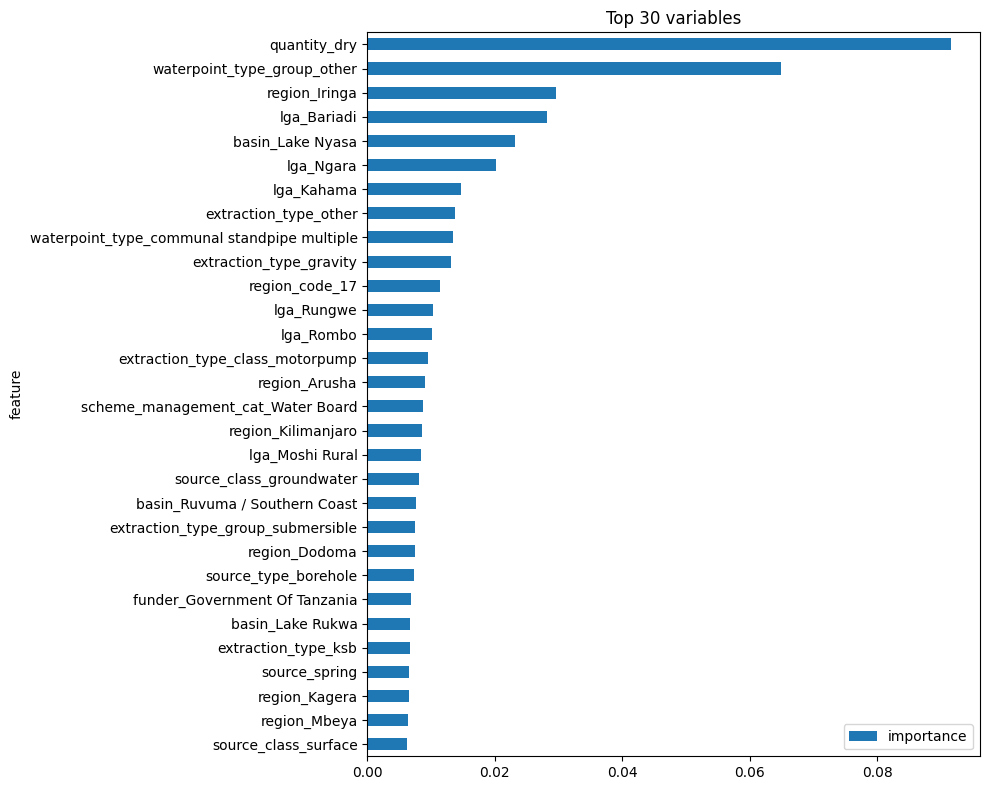

In [76]:
# Extraer pasos del pipeline
preprocesador = pipeline_xgb_rare.named_steps['preprocessor']
modelo = pipeline_xgb_rare.named_steps['classifier']

# Obtener nombres manualmente de columnas transformadas
def obtener_nombres_columnas_transformadas(preprocessor):
    nombres_finales = []

    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if isinstance(transformer, Pipeline):
            ultimo_step = transformer.steps[-1][1]
        else:
            ultimo_step = transformer
        try:
            nombres = ultimo_step.get_feature_names_out(columns)
        except:
            nombres = columns  # fallback si no tiene método
        nombres_finales.extend(nombres)
    return nombres_finales

columnas_transformadas = obtener_nombres_columnas_transformadas(preprocesador)

# Obtener importancias
importancias = modelo.feature_importances_

# Crear DataFrame con importancias
importancias_df = pd.DataFrame({
    'feature': columnas_transformadas,
    'importance': importancias
}).sort_values(by='importance', ascending=False)

# Visualizar top 30
importancias_df.head(30).plot.barh(x='feature', y='importance', figsize=(10, 8), title="Top 30 variables")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Paso 6: Guardar top 50
top_vars_xgb_rare_001 = importancias_df.head(50)['feature'].tolist()

In [77]:
len(importancias_df)


321

### MODELO XGBOOST CON LAS 100 VARIABLES MÁS IMPORTANTES

In [79]:
# Seleccionar top 100 columnas transformadas
top_100_vars = importancias_df.head(100)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top100 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_100_vars]
X_top100 = X_top100.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top100 = XGBClassifier(random_state=42, eval_metric='mlogloss')
modelo_top100.fit(X_top100, y_full)

# Evaluación por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    modelo_top100,
    X_top100,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
import numpy as np
print("\n Resultados CV para XGBoost con top 100 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top100,
    nombre_modelo="XGBoost_top100_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_100_vars,
    metrics=metrics,
    params={"rare_threshold": 0.01, "n_top_vars": 100}
)


 Resultados CV para XGBoost con top 100 variables importantes:
 Accuracy medio:     0.7857
 F1 macro medio:     0.6463
 F1 weighted medio:  0.7726


2025/04/30 13:53:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO XGBOOST CON LAS 200 VARIABLES MÁS IMPORTANTES

In [80]:
# Seleccionar top 100 columnas transformadas
top_200_vars = importancias_df.head(200)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top200 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_200_vars]
X_top200 = X_top200.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top200 = XGBClassifier(random_state=42, eval_metric='mlogloss')
modelo_top200.fit(X_top200, y_full)

# Evaluación por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    modelo_top200,
    X_top200,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
import numpy as np
print("\n Resultados CV para XGBoost con top 200 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top200,
    nombre_modelo="XGBoost_top200_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_200_vars,
    metrics=metrics,
    params={"rare_threshold": 0.01, "n_top_vars": 200}
)


 Resultados CV para XGBoost con top 200 variables importantes:
 Accuracy medio:     0.7984
 F1 macro medio:     0.6669
 F1 weighted medio:  0.7869


2025/04/30 14:00:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO XGBOOST CON LAS 200 VARIABLES MÁS IMPORTANTES

In [88]:
# Seleccionar top 100 columnas transformadas
top_225_vars = importancias_df.head(225)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top225 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_225_vars]
X_top225 = X_top225.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top225 = XGBClassifier(random_state=42, eval_metric='mlogloss')
modelo_top225.fit(X_top225, y_full)

# Evaluación por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    modelo_top225,
    X_top225,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
import numpy as np
print("\n Resultados CV para XGBoost con top 225 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top225,
    nombre_modelo="XGBoost_top225_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_225_vars,
    metrics=metrics,
    params={"rare_threshold": 0.01, "n_top_vars": 225}
)


 Resultados CV para XGBoost con top 200 variables importantes:
 Accuracy medio:     0.7978
 F1 macro medio:     0.6656
 F1 weighted medio:  0.7862


2025/04/30 14:46:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO XGBOOST CON LAS 150 VARIABLES MÁS IMPORTANTES

In [81]:
# Seleccionar top 100 columnas transformadas
top_150_vars = importancias_df.head(150)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top150 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_150_vars]
X_top150 = X_top150.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top150 = XGBClassifier(random_state=42, eval_metric='mlogloss')
modelo_top150.fit(X_top150, y_full)

# Evaluación por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    modelo_top150,
    X_top150,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
import numpy as np
print("\n Resultados CV para XGBoost con top 200 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top150,
    nombre_modelo="XGBoost_top150_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_150_vars,
    metrics=metrics,
    params={"rare_threshold": 0.01, "n_top_vars": 150}
)


 Resultados CV para XGBoost con top 200 variables importantes:
 Accuracy medio:     0.7962
 F1 macro medio:     0.6623
 F1 weighted medio:  0.7842


2025/04/30 14:07:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO XGBOOST CON LAS 250 VARIABLES MÁS IMPORTANTES

In [82]:
# Seleccionar top 250 columnas transformadas
top_250_vars = importancias_df.head(250)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top250 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_250_vars]
X_top250 = X_top250.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top250 = XGBClassifier(random_state=42, eval_metric='mlogloss')
modelo_top250.fit(X_top250, y_full)

# Evaluación por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    modelo_top250,
    X_top250,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
import numpy as np
print("\n Resultados CV para XGBoost con top 250 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top250,
    nombre_modelo="XGBoost_top250_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_250_vars,
    metrics=metrics,
    params={"rare_threshold": 0.01, "n_top_vars": 250}
)



 Resultados CV para XGBoost con top 250 variables importantes:
 Accuracy medio:     0.7966
 F1 macro medio:     0.6640
 F1 weighted medio:  0.7848


2025/04/30 14:10:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Selección de variables en Random Forest

In [83]:
# Pipeline con RareLabel (threshold=0.01)
high_card_pipeline_rare_001 = Pipeline(steps=[
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.01)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipelines restantes (iguales para todos)
medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

# ColumnTransformer con RareLabel (th=0.01)
preprocessor_rare_001 = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_rare_001, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

# Pipeline completo
pipeline_rf_rare_001 = Pipeline([
    ('preprocessor', preprocessor_rare_001),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Evaluación con validación cruzada
scores_rf_rare_001 = evaluar_modelo_cv_multiclase(
    pipeline_rf_rare_001, X_full, y_full,
    nombre="Random Forest + RareLabel + OneHot (th=0.01)"
)

# Entrenamiento final del modelo
pipeline_rf_rare_001.fit(X_full, y_full)


 Resultados CV para Random Forest + RareLabel + OneHot (th=0.01) (5-fold):
 Accuracy medio:     0.8028
 F1 macro medio:     0.6890
 F1 weighted medio:  0.7979


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('high_card',
                                                  Pipeline(steps=[('rare',
                                                                   RareLabelEncoder(variables=['funder',
                                                                                               'installer',
                                                                                               'ward',
                                                                                               'lga',
                                                                                               'subvillage_cat',
                                                                                               'subvillage_imp'])),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['funder', 'installer',
                                                   'ward', 'lga',
                                                   'subvillage_cat',
                                                   'subvillage_imp']),
                                                 ('mediu...
                                                  Pipeline(steps=[('identity',
                                                                   FunctionTransformer())]),
                                                  ['has_construction_info',
                                                   'zero_amount_tsh',
                                                   'low_amount_tsh',
                                                   'public_meeting_imp',
                                                   'permit_imp']),
                                                 ('numeric', 'passthrough',
                                                  ['amount_tsh_log',
                                                   'gps_height_imp',
                                                   'longitude_imp', 'latitude',
                                                   'age', 'population',
                                                   'year_recorded',
                                                   'month_recorded',
                                                   'recorded_quarter'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Extracción de variables más importantes para RandomForest y construcción de modelos.
Exactamente igual que hemos procedido con el modelo de XGBoost, extraeremos las variables más importantes para el modelo RandomForest y construiremos distintos modelos probando diferentes de las mismas para la construcción del modelo.

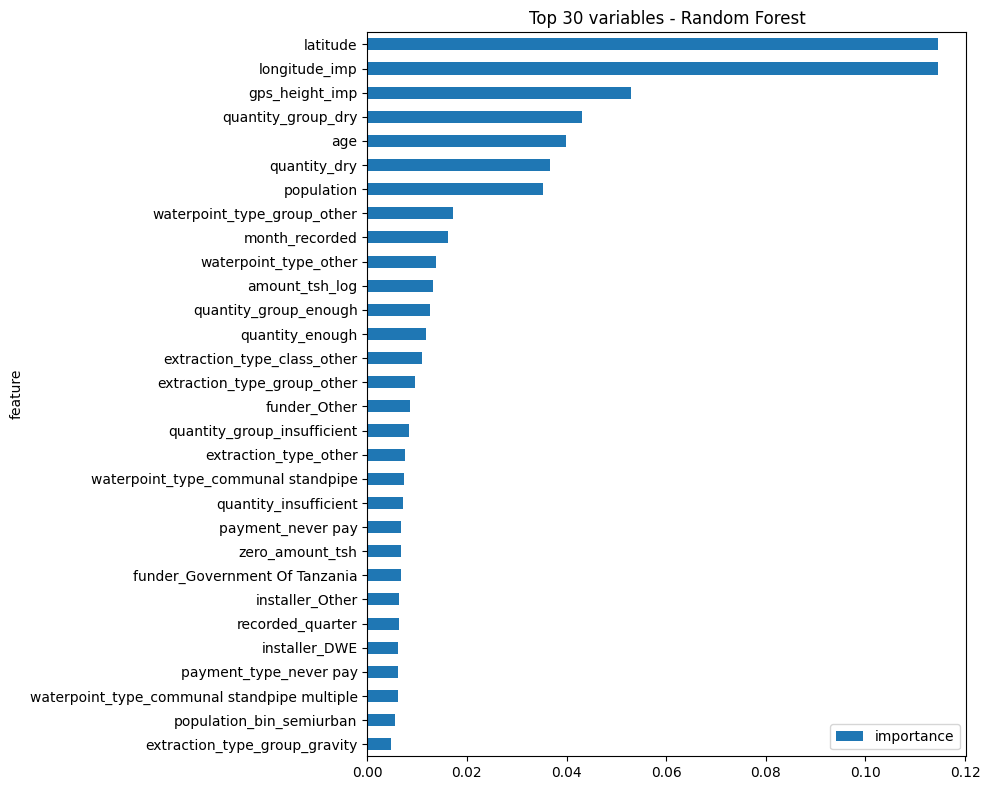

In [85]:
# Extraer pasos del pipeline
preprocesador_rf = pipeline_rf_rare_001.named_steps['preprocessor']
modelo_rf = pipeline_rf_rare_001.named_steps['classifier']

# Obtener nombres manualmente de columnas transformadas
def obtener_nombres_columnas_transformadas(preprocessor):
    nombres_finales = []
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if isinstance(transformer, Pipeline):
            ultimo_step = transformer.steps[-1][1]
        else:
            ultimo_step = transformer
        try:
            nombres = ultimo_step.get_feature_names_out(columns)
        except:
            nombres = columns
        nombres_finales.extend(nombres)
    return nombres_finales

columnas_transformadas_rf = obtener_nombres_columnas_transformadas(preprocesador_rf)

# Obtener importancias
importancias_rf = modelo_rf.feature_importances_

# Crear DataFrame con importancias
importancias_df_rf = pd.DataFrame({
    'feature': columnas_transformadas_rf,
    'importance': importancias_rf
}).sort_values(by='importance', ascending=False)

# Visualizar top 30
importancias_df_rf.head(30).plot.barh(x='feature', y='importance', figsize=(10, 8), title="Top 30 variables - Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Guardar top 50
top_vars_rf_rare_001 = importancias_df_rf.head(50)['feature'].tolist()


### MODELO RANDOM FOREST CON LAS 100 VARIABLES MÁS IMPORTANTES

In [86]:
# Seleccionar top 100 columnas transformadas
top_100_vars_rf = importancias_df_rf.head(100)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado_rf = preprocesador_rf.transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top100_rf = pd.DataFrame(X_full_transformado_rf, columns=columnas_transformadas_rf, index=X_full.index)[top_100_vars_rf]
X_top100_rf = X_top100_rf.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top100_rf = RandomForestClassifier(random_state=42)
modelo_top100_rf.fit(X_top100_rf, y_full)

# Evaluación por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_rf = cross_validate(
    modelo_top100_rf,
    X_top100_rf,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
print("\n Resultados CV para Random Forest con top 100 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores_rf['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores_rf['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores_rf['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics_rf = {
    "accuracy": np.mean(scores_rf['test_accuracy']),
    "f1_macro": np.mean(scores_rf['test_f1_macro']),
    "f1_weighted": np.mean(scores_rf['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top100_rf,
    nombre_modelo="RandomForest_top100_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_100_vars_rf,
    metrics=metrics_rf,
    params={"rare_threshold": 0.01, "n_top_vars": 100}
)


 Resultados CV para Random Forest con top 100 variables importantes:
 Accuracy medio:     0.8026
 F1 macro medio:     0.6893
 F1 weighted medio:  0.7977


2025/04/30 14:23:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO RANDOM FOREST CON LAS 200 VARIABLES MÁS IMPORTANTES

In [87]:
# Seleccionar top 200 columnas transformadas
top_200_vars_rf = importancias_df_rf.head(200)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado_rf = preprocesador_rf.transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top200_rf = pd.DataFrame(X_full_transformado_rf, columns=columnas_transformadas_rf, index=X_full.index)[top_200_vars_rf]
X_top200_rf = X_top200_rf.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top200_rf = RandomForestClassifier(random_state=42)
modelo_top200_rf.fit(X_top200_rf, y_full)

# Evaluación por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_rf = cross_validate(
    modelo_top200_rf,
    X_top200_rf,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
print("\n Resultados CV para Random Forest con top 200 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores_rf['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores_rf['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores_rf['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics_rf = {
    "accuracy": np.mean(scores_rf['test_accuracy']),
    "f1_macro": np.mean(scores_rf['test_f1_macro']),
    "f1_weighted": np.mean(scores_rf['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top200_rf,
    nombre_modelo="RandomForest_top200_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_200_vars_rf,
    metrics=metrics_rf,
    params={"rare_threshold": 0.01, "n_top_vars": 200}
)



 Resultados CV para Random Forest con top 200 variables importantes:
 Accuracy medio:     0.8040
 F1 macro medio:     0.6899
 F1 weighted medio:  0.7991


2025/04/30 14:29:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Selección del mejor modelo para su posterior mejora.
Una vez hemos determinado cual es el mejor modelo y la mejor combinación de variables, habiendo resultado el modelo XGBoost con las 200 variables más importantes, seleccionaremos este modelo para intentar realizar mejoras por diferentes técnicas para intentar mejorar sus métricas.

In [ ]:
# Definir los datos
top_200_vars = importancias_df.head(200)['feature'].tolist()
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)
X_top200 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_200_vars]
X_top200 = X_top200.apply(pd.to_numeric, errors='coerce')

# Definir el modelo y los hiperparámetros a ajustar
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Configurar la validación cruzada y el grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo
grid_search.fit(X_top200, y_full)

# Extraer el mejor modelo y métricas
mejor_modelo = grid_search.best_estimator_
mejores_params = grid_search.best_params_

# Evaluación cruzada con el mejor modelo
scores = cross_validate(
    mejor_modelo,
    X_top200,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

print("\n Resultados CV con XGBoost tuneado (top 200 variables):")
print(f" Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# 6. Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=mejor_modelo,
    nombre_modelo="XGBoost_top200_tuneado",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_200_vars,
    metrics=metrics,
    params={**mejores_params, "rare_threshold": 0.01, "n_top_vars": 200}
)


##  Evaluación del modelo optimizado con XGBoost y selección de variables

Tras realizar un proceso de selección de características basado en la importancia de las variables, se ha construido un modelo **XGBoost** utilizando las **200 variables más relevantes**. Posteriormente, se ha llevado a cabo una optimización fina de hiperparámetros mediante validación cruzada estratificada, lo que ha permitido mejorar el rendimiento del modelo de forma notable respecto a la versión base.

###  Configuración del modelo final

- **Codificación aplicada**: `RareLabelEncoder (threshold=0.01)` + `OneHotEncoder`
- **Número de variables seleccionadas**: `200` (según importancia en el modelo original)
- **Hiperparámetros ajustados**:
  - `n_estimators = 200`
  - `max_depth = 8`
  - `learning_rate = 0.2`
  - `colsample_bytree = 0.6`
  - `subsample = 0.8`

###  Resultados (Validación cruzada 5-fold)

- **Accuracy**: **0.8109**
- **F1 macro**: 0.6926
- **F1 weighted**: 0.8029

Este modelo se consolida como el **mejor modelo entrenado hasta el momento** y se usará como base para futuros intentos de mejora.



### Prueba de mejor modelo con balanceo de clases

In [97]:
y_full.value_counts(normalize=True)

status_group_num
2.0    0.543081
0.0    0.384242
1.0    0.072677
Name: proportion, dtype: float64

In [101]:
# Recalcular pesos por clase (multiclase)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_full)

#  Definir modelo con mejores hiperparámetros encontrados
xgb_balanced = XGBClassifier(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
    eval_metric='mlogloss'
)

# Entrenar el modelo usando sample_weight
xgb_balanced.fit(X_top200, y_full, sample_weight=sample_weights)

# Evaluar con CV usando sample_weight también
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    xgb_balanced,
    X_top200,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    fit_params={"sample_weight": sample_weights},
    return_train_score=False
)

# Mostrar resultados
print("\nResultados CV con XGBoost balanceado:")
print(f"Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f"F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f"F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=xgb_balanced,
    nombre_modelo="XGBoost_top200_balanceado",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_200_vars,
    metrics=metrics,
    params={
        "rare_threshold": 0.01,
        "n_top_vars": 200,
        "n_estimators": 200,
        "learning_rate": 0.2,
        "max_depth": 8,
        "subsample": 0.8,
        "colsample_bytree": 0.6,
        "sample_weight": "balanced"
    }
)

C:\Users\migue\anaconda3\envs\ML2025\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



Resultados CV con XGBoost balanceado:
Accuracy medio:     0.7681
F1 macro medio:     0.6827
F1 weighted medio:  0.7802


2025/04/30 16:24:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Hemos tenido una pérdida en todas las métricas así que no continuaremos por esta vía y buscaremos otras opciones de mejora.

### Introducción de variables complejas
Para mejorar la capacidad predictiva del modelo, se han creado nuevas variables derivadas de relaciones lógicas entre columnas existentes. Estas transformaciones permiten capturar información que no está explícita en las variables originales, como la densidad poblacional relativa, la antigüedad del pozo o patrones espaciales.

Las variables añadidas han sido:

- **`population_per_height`**: ratio entre la población abastecida y la altitud del pozo, para detectar concentraciones de población en zonas bajas.
- **`has_installer_info`**: variable binaria que indica si existe información fiable sobre el instalador del pozo.
- **`is_old_construction`**: identifica si el pozo fue construido antes de 1980, como posible señal de desgaste.
- **`lat_long_cluster`**: agrupación espacial mediante K-Means sobre latitud y longitud, útil para detectar regiones homogéneas.
- **`amount_tsh_per_capita`**: relación entre el volumen de agua disponible (`amount_tsh`) y la población, como proxy de eficiencia o dotación.

Estas nuevas características enriquecen el dataset con señales potencialmente relevantes para la predicción del estado operativo de los pozos.


In [108]:
from sklearn.cluster import KMeans
# Crear nuevas variables complejas
X_full['population_per_height'] = X_full['population'] / (X_full['gps_height_imp'] + 1)
X_full['has_installer_info'] = X_full['installer'].apply(lambda x: 0 if pd.isna(x) or str(x).strip().lower() in ['', '0', 'unknown', 'none'] else 1)
X_full['is_old_construction'] = X_full['construction_year'].apply(lambda x: 1 if x != 0 and x < 1980 else 0)
X_full['amount_tsh_per_capita'] = X_full.apply(lambda row: row['amount_tsh'] / row['population'] if row['population'] > 0 else 0, axis=1)
# Crear nuevas variables complejas (añadidas a las que ya tienes)
X_full['lat_long_cluster'] = -1
# Usar variables imputadas de coordenadas
coords = X_full[['latitude', 'longitude_imp']].copy()
coords = coords[(coords['latitude'] != 0) & (coords['longitude_imp'] != 0)]
# Aplicar clustering geográfico
kmeans = KMeans(n_clusters=10, random_state=42)
X_full.loc[coords.index, 'lat_long_cluster'] = kmeans.fit_predict(coords)

In [109]:
X_full.columns

Index(['amount_tsh', 'funder', 'installer', 'latitude', 'num_private', 'basin',
       'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'amount_tsh_log',
       'public_meeting_cat', 'permit_cat', 'scheme_management_cat',
       'subvillage_cat', 'public_meeting_imp', 'permit_imp',
       'scheme_management_imp', 'subvillage_imp', 'gps_height_imp',
       'longitude_imp', 'has_construction_info', 'low_amount_tsh',
       'population_bin', 'year_recorded', 'month_recorded', 'recorded_quarter',
       'age', 'zero_amount_tsh', 'population_per_height', 'has_installer_info',
       'is_old_construction', 'amount_tsh_per_capita', 'lat_long_

In [110]:
X_full

,amount_tsh,funder,installer,latitude,num_private,basin,region,region_code,district_code,lga,...,year_recorded,month_recorded,recorded_quarter,age,zero_amount_tsh,population_per_height,has_installer_info,is_old_construction,amount_tsh_per_capita,lat_long_cluster
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,Roman,-9.856322,0,Lake Nyasa,Iringa,11,5,Ludewa,...,2011,3,1,12.0,0,0.078361,1,0,55.045872,2
8776,0.0,Grumeti,GRUMETI,-2.147466,0,Lake Victoria,Mara,20,2,Serengeti,...,2013,3,1,3.0,1,0.200000,1,0,0.000000,8
34310,25.0,Lottery Club,World vision,-3.821329,0,Pangani,Manyara,21,4,Simanjiro,...,2013,2,1,4.0,0,0.363901,1,0,0.100000,4
67743,0.0,Unicef,UNICEF,-11.155298,0,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,...,2013,1,1,27.0,1,0.219697,1,0,0.000000,6
19728,0.0,Action In A,Artisan,-1.825359,0,Lake Victoria,Kagera,18,1,Karagwe,...,2011,7,3,NaN,1,0.000000,1,0,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10.0,Germany Republi,CES,-3.253847,0,Pangani,Kilimanjaro,3,5,Hai,...,2013,5,2,14.0,0,0.103220,1,0,0.080000,4
27263,4700.0,Cefa-njombe,Cefa,-9.070629,0,Rufiji,Iringa,11,4,Njombe,...,2011,5,2,15.0,0,0.046167,1,0,83.928571,2
37057,0.0,Unknown,Unknown,-8.750434,0,Rufiji,Mbeya,12,7,Mbarali,...,2011,4,2,NaN,1,0.000000,0,0,0.000000,3


### Pruebas con las nuevas variables

In [114]:
# Nuevas variables 
num_vars_ext = num_vars + ['population_per_height', 'amount_tsh_per_capita', 'lat_long_cluster']
binary_vars_ext = binary_vars + ['has_installer_info', 'is_old_construction']

# Preprocesamiento
high_card_pipeline = Pipeline([
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.01)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline, high_card_vars),
    ('medium_card', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), medium_card_vars),
    ('low_card', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), one_hot_vars),
    ('binary', FunctionTransformer(validate=False), binary_vars_ext),
    ('numeric', 'passthrough', num_vars_ext)
])

# Pipeline completo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=200,
        learning_rate=0.2,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.6,
        eval_metric='mlogloss',
        random_state=42
    ))
])
pipeline.fit(X_full, y_full)

# Extraer importancias y seleccionar top 200
modelo = pipeline.named_steps['classifier']
preprocesador = pipeline.named_steps['preprocessor']
def obtener_nombres_columnas_(preprocessor):
    nombres_finales = []
    for nombre, transformador, columnas in preprocessor.transformers_:
        if nombre == 'remainder':
            continue
        if isinstance(transformador, Pipeline):
            ultimo = transformador.steps[-1][1]
        else:
            ultimo = transformador
        try:
            nombres = ultimo.get_feature_names_out(columnas)
        except Exception:
            nombres = columnas  # fallback para los que no lo soportan
        nombres_finales.extend(nombres)
    return nombres_finales

col_names = obtener_nombres_columnas_(preprocesador)
importancias = modelo.feature_importances_
importancias_df = pd.DataFrame({'feature': col_names, 'importance': importancias}).sort_values(by='importance', ascending=False)
top_200 = importancias_df.head(200)['feature'].tolist()
X_trans = preprocesador.transform(X_full)
X_top200 = pd.DataFrame(X_trans, columns=col_names, index=X_full.index)[top_200].apply(pd.to_numeric, errors='coerce')

In [115]:
# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    modelo, X_top200, y_full,
    scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro', 'f1_weighted': 'f1_weighted'},
    cv=cv, return_train_score=False
)

# Resultados
print("\nResultados CV con variables complejas (top 200):")
print(f"Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f"F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f"F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}
registrar_resultado_mlflow(
    modelo=modelo,
    nombre_modelo="XGBoost_top200_engineered",
    nombre_codificacion="RareLabel + OneHot (th=0.01) + engineered",
    variables_usadas=top_200,
    metrics=metrics,
    params={
        "rare_threshold": 0.01,
        "n_top_vars": 200,
        "engineered_features": True,
        "n_estimators": 200,
        "max_depth": 8,
        "learning_rate": 0.2,
        "colsample_bytree": 0.6,
        "subsample": 0.8
    }
)


Resultados CV con variables complejas (top 200):
Accuracy medio:     0.7992
F1 macro medio:     0.6760
F1 weighted medio:  0.7902


2025/04/30 17:13:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [116]:
# Definir el conjunto de datos con las 200 nuevas variables ya seleccionadas
X_top200 = X_top200  
y = y_full           

# Definir modelo base
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Definir la malla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Configurar la validación cruzada y GridSearch
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo
grid_search.fit(X_top200, y)

# Evaluación del mejor modelo
mejor_modelo = grid_search.best_estimator_
mejores_params = grid_search.best_params_

scores = cross_validate(
    mejor_modelo,
    X_top200,
    y,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

print("\n Resultados CV con nuevas variables y XGBoost tuneado:")
print(f"Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f"F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f"F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# 7. Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=mejor_modelo,
    nombre_modelo="XGBoost_top200_tuneado_nuevas_vars",
    nombre_codificacion="RareLabel + OneHot (th=0.01) + nuevas variables",
    variables_usadas=top_200,
    metrics=metrics,
    params={**mejores_params, "rare_threshold": 0.01, "n_top_vars": 200}
)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

🔎 Resultados CV con nuevas variables y XGBoost tuneado:
Accuracy medio:     0.7992
F1 macro medio:     0.6760
F1 weighted medio:  0.7902


2025/04/30 17:58:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Podemos llegar a la conclusión de que estas nuevas variables no han mejorado en absoluto el modelo porque las métricas han empeorado y en al buscar los mejores hiperparámetros las métricas son las mismas. Intentaremos mejorar por otro lado nuestro modelo.

In [117]:
X_top200

,quantity_dry,quantity_group_dry,waterpoint_type_other,extraction_type_group_other,lga_Bariadi,waterpoint_type_group_other,lga_Rombo,lga_Ngara,region_Iringa,lga_Kigoma Rural,...,district_code_6,quantity_group_enough,payment_pay monthly,basin_Wami / Ruvu,permit_cat_True,region_code_6,lga_Same,management_water board,source_shallow well,public_meeting_cat_False
id,,,,,,,,,,,,,,,,,,,,,
69572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
34310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
67743,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
27263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
37057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Análisis de errores y matriz de confusión con el mejor modelo hasta el momento

In [118]:
# Definir modelo con los mejores hiperparámetros
xgb_final = XGBClassifier(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.6,
    eval_metric='mlogloss',
    random_state=42
)
# Entrenar con las 200 variables más importantes
xgb_final.fit(X_top200, y_full)
# Predicciones y probabilidades
y_pred = xgb_final.predict(X_top200)
y_proba = xgb_final.predict_proba(X_top200)

 Clasificación con umbral por defecto:
              precision    recall  f1-score   support

         0.0       0.90      0.79      0.84     22824
         1.0       0.73      0.40      0.52      4317
         2.0       0.82      0.94      0.88     32259

    accuracy                           0.84     59400
   macro avg       0.82      0.71      0.74     59400
weighted avg       0.84      0.84      0.84     59400



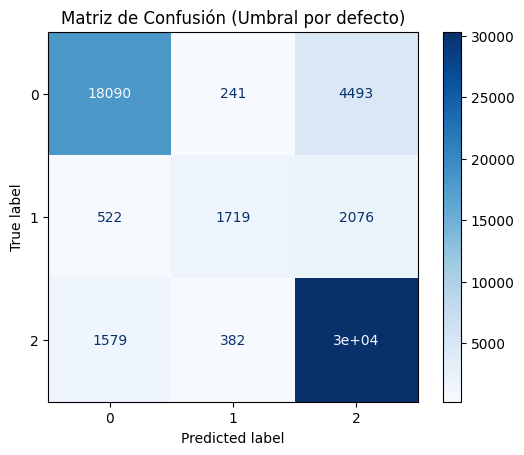

In [122]:
# Matriz de confusión y reporte con umbral por defecto
print(" Clasificación con umbral por defecto:")
print(classification_report(y_full, y_pred))

cm = confusion_matrix(y_full, y_pred)
ConfusionMatrixDisplay(cm, display_labels=xgb_final.classes_).plot(cmap='Blues')
plt.title("Matriz de Confusión (Umbral por defecto)")
plt.show()

###  Análisis de errores con el umbral por defecto

Una vez entrenado el modelo optimizado, se ha evaluado su rendimiento detallado mediante el informe de clasificación y la matriz de confusión. Aunque el modelo alcanza una **accuracy del 84%**, se observa un **claro desequilibrio en el rendimiento entre clases**.

- La clase **1 (functional needs repair)** es la más perjudicada, con un *recall* del **40%** y un *f1-score* de **0.52**, lo que indica que muchos ejemplos de esta clase se están clasificando erróneamente como clase 0 o clase 2.
- Por el contrario, la clase **2 (functional)** obtiene el mejor rendimiento con un *recall* del **94%** y un *f1-score* de **0.88**.

Estos resultados muestran que el modelo **tiene un sesgo hacia la clase mayoritaria**, por lo que el siguiente paso será ajustar los umbrales de decisión personalizados para mejorar la detección de la clase minoritaria sin sacrificar el rendimiento general.


In [124]:

# Configuración
umbral_clase_1 = 0.2
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Métricas acumuladas
accs = []
f1_macros = []
f1_weighteds = []

for train_idx, val_idx in cv.split(X_top200, y_full):
    X_train, X_val = X_top200.iloc[train_idx], X_top200.iloc[val_idx]
    y_train, y_val = y_full.iloc[train_idx], y_full.iloc[val_idx]

    # Entrenar modelo con mejores hiperparámetros
    model = XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.2,
        colsample_bytree=0.6,
        subsample=0.8,
        random_state=42,
        eval_metric='mlogloss'
    )
    model.fit(X_train, y_train)

    # Predicción de probabilidades y ajuste de umbral clase 1
    y_proba = model.predict_proba(X_val)
    y_pred = []
    for fila in y_proba:
        if fila[1] > umbral_clase_1:
            y_pred.append(1)
        else:
            y_pred.append(np.argmax(fila))

    # Calcular métricas
    accs.append(accuracy_score(y_val, y_pred))
    f1_macros.append(f1_score(y_val, y_pred, average='macro'))
    f1_weighteds.append(f1_score(y_val, y_pred, average='weighted'))

# Promedio de resultados
accuracy = np.mean(accs)
f1_macro = np.mean(f1_macros)
f1_weighted = np.mean(f1_weighteds)

print("\n Resultados CV ajustando umbral clase 1:")
print(f" Accuracy medio:     {accuracy:.4f}")
print(f" F1 macro medio:     {f1_macro:.4f}")
print(f" F1 weighted medio:  {f1_weighted:.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": accuracy,
    "f1_macro": f1_macro,
    "f1_weighted": f1_weighted
}

registrar_resultado_mlflow(
    modelo=model,
    nombre_modelo="XGBoost_top200_umbral_cv",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_200,
    metrics=metrics,
    params={
        "rare_threshold": 0.01,
        "n_top_vars": 200,
        "umbral_clase_1": umbral_clase_1,
        "n_estimators": 200,
        "max_depth": 8,
        "learning_rate": 0.2,
        "colsample_bytree": 0.6,
        "subsample": 0.8
    }
)


 Resultados CV ajustando umbral clase 1:
 Accuracy medio:     0.7753
 F1 macro medio:     0.6797
 F1 weighted medio:  0.7802


2025/04/30 18:38:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# GUARDADO DEL MEJOR MODELO PARA PREDICCIÓN SOBRE EL CONJUNTO DE TEST

In [125]:
resultados_modelos

,nombre_modelo,codificacion,accuracy,f1_macro,f1_weighted,params
0,XGBoost_modelo_base_Rarelabel001,RareLabel + OneHot,0.798418,0.665391,0.786598,{'rare_threshold': 0.01}
1,XGBoost_modelo_base_Rarelabel001,RareLabel + OneHot,0.798418,0.665391,0.786598,{'rare_threshold': 0.01}
2,XGBoost_modelo_base_Rarelabel005,RareLabel + OneHot,0.796818,0.663552,0.785097,{'rare_threshold': 0.05}
3,XGBoost_modelo_base_TargetEncoder,TargetEncoder,0.755993,0.636313,0.748371,{'encoder': 'target'}
4,RandomForest_modelo_base_Rarelabel001,RareLabel + OneHot,0.802778,0.689050,0.797924,{'rare_threshold': 0.01}
5,RandomForest_modelo_base_Rarelabel005,RareLabel + OneHot,0.802374,0.688529,0.797407,{'rare_threshold': 0.05}
6,RandomForest_modelo_base_TargetEncoder,TargetEncoder,0.772542,0.665336,0.768277,-
7,XGBoost_top100_importancias,RareLabel + OneHot (th=0.01),0.785673,0.646288,0.772593,"{'rare_threshold': 0.01, 'n_top_vars': 100}"
8,XGBoost_top200_importancias,RareLabel + OneHot (th=0.01),0.798418,0.666879,0.786948,"{'rare_threshold': 0.01, 'n_top_vars': 200}"
9,XGBoost_top150_importancias,RareLabel + OneHot (th=0.01),0.796229,0.662346,0.784198,"{'rare_threshold': 0.01, 'n_top_vars': 150}"


### Elección final, guardado y predicción: XGBoost_top200_tuneado que tiene las mejores métricas de todas las pruebas realizadas

In [126]:
# Transformar X_full con preprocesador ya entrenado
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)
X_top200 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_200_vars]
X_top200 = X_top200.apply(pd.to_numeric, errors='coerce')

# Entrenar el mejor modelo
xgb_final = XGBClassifier(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.6,
    eval_metric='mlogloss',
    random_state=42
)
xgb_final.fit(X_top200, y_full)

# Guardar modelo y variables
joblib.dump(xgb_final, "modelo_xgb_final.pkl")
joblib.dump(top_200_vars, "top_200_vars.pkl")
joblib.dump(columnas_transformadas, "columnas_transformadas.pkl")
joblib.dump(pipeline_xgb_rare, "pipeline_xgb_rare.pkl")

['pipeline_xgb_rare.pkl']

In [130]:
# Cargar modelo y objetos necesarios
xgb_final = joblib.load("modelo_xgb_final.pkl")
top_200_vars = joblib.load("top_200_vars.pkl")
columnas_transformadas = joblib.load("columnas_transformadas.pkl")
pipeline_xgb_rare = joblib.load("pipeline_xgb_rare.pkl")

# Cargar test
X_test = pd.read_parquet("X_test_preparado.parquet")

# Transformar y seleccionar variables
X_test_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_test)
X_test_top200 = pd.DataFrame(X_test_transformado, columns=columnas_transformadas, index=X_test.index)[top_200_vars]
X_test_top200 = X_test_top200.apply(pd.to_numeric, errors='coerce')

# Predecir
y_pred = xgb_final.predict(X_test_top200)

# Mapear predicciones a etiquetas reales
mapeo_etiquetas = {
    0: 'non functional',
    1: 'functional needs repair',
    2: 'functional'
}
y_pred_labels = pd.Series(y_pred).map(mapeo_etiquetas)

# Crear archivo de envío en el formato requerido
df_submission = pd.DataFrame({
    'id': X_test.index,
    'status_group': y_pred_labels
})
df_submission.to_csv("submission.csv", index=False)